In [ ]:
!pip install --upgrade pymc-marketing pymc arviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.1/131.1 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.6/484.6 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.2 MB/s eta 0:00:00
  Attempting uninstall: pytensor
    Found existing installation: pytensor 2.18.6
    Uninstalling pytensor-2.18.6:
      Successfully uninstalled pytensor-2.18.6
  Attempting uninstall: arviz
    Found existing installation: arviz 0.15.1
    Uninstalling arviz-0.15.1:
      Successfully uninstalled arviz-0.15.1
  Attempting uninstall: pymc
    Found existing installation: pymc 5.10.4
    Uninstalling pymc-5.10.4:
      Successfully uninstalled pymc-5.10.4


In [ ]:
import pandas as pd
import numpy as np

import pymc as pm
from pymc_marketing.mmm import DelayedSaturatedMMM,MMM

import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

Data Generation

In [ ]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

# date range
min_date = pd.to_datetime("2020-01-01")
max_date = pd.to_datetime("2023-12-01")

df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 204


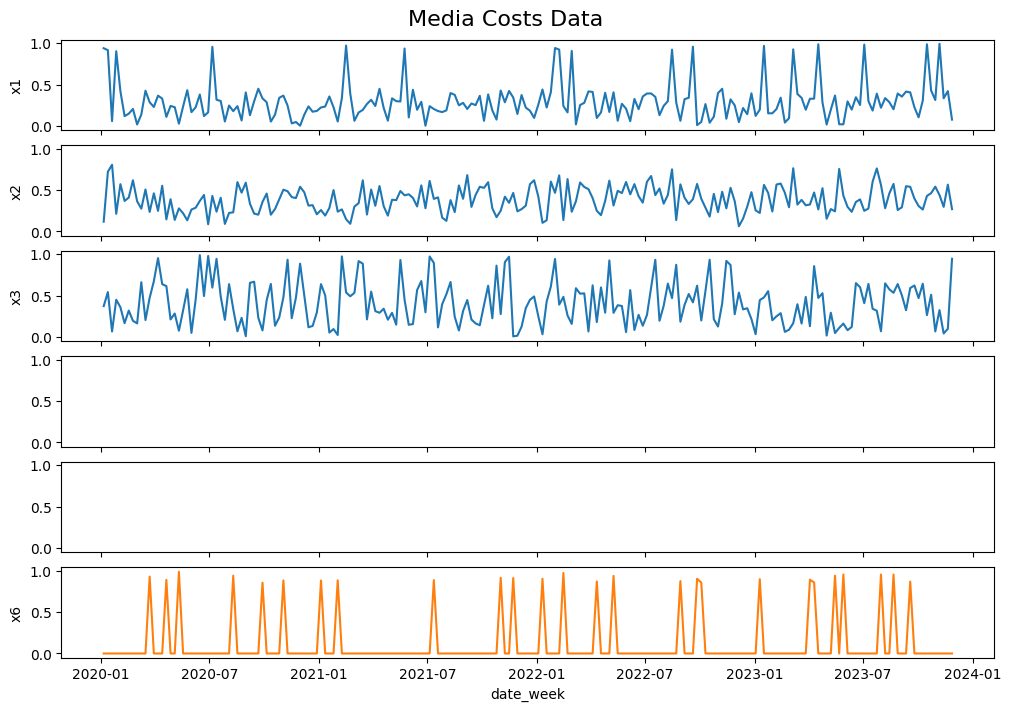

In [ ]:
# media data
x1 = rng.uniform(low=0.0, high=1.0, size=n)
df["x1"] = np.where(x1 > 0.9, x1, x1 / 2)
from scipy import stats

# # x1 = rng.uniform(low=0.0, high=1.0, size=n) *1000
# x1 = np.random.beta(a=2, b=6, size=n) * 1000  # Adjust a and b parameters for the skew

# df["x3"] = np.where(x1 > 0.85, x1, x1 / 2)


# x2 = rng.uniform(low=0.0, high=1.0, size=n)
# df["x2"] = np.where(x2 > 0.8, x2, 0) * 1000


# Digital Advertising (X1, X3, X4, X5)
# df["x1"] = np.random.beta(a=2, b=4, size=n)   # Base value with slight downside skew
# df["x1"] += 500 * np.sin(2 * np.pi * df["date_week"].dt.dayofyear / 365)  # Seasonality (annual)

df["x2"] = np.random.beta(a=3, b=5, size=n)  # Base value with slight downside skew
# df["x3"] += 200 * np.sin(2 * np.pi * df["date_week"].dt.isocalendar().week / 52)  # Seasonality (quarterly)

# ... Implement similar logic for X4 and X5 with different seasonal patterns

x3 = rng.uniform(low=0.0, high=1.0, size=n)
df["x3"] = np.where(x3 > 0.85, x3, x3 / 1.25)
# x4 = np.random.beta(a=4, b=2, size=n)
# df["x4"] =  np.where(x4 > 0.8, x4, x4 / 1.3)

# Traditional Advertising (X2, X6)
# df["x5"] = stats.binom.rvs(n=1, p=0.1, size=n)  # Infrequent, significant spending events
# df["x6"] = stats.binom.rvs(n=1, p=0.15, size=n) # More frequent, smaller spending events

# x5 = rng.uniform(low=0.0, high=1.0, size=n)
# df["x5"] = np.where(x5 > 0.75, x5, 0)

x6 = rng.uniform(low=0.0, high=1.0, size=n)
df["x6"] = np.where(x6 > 0.85, x6, 0)

# df["x5"] = np.random.beta(a=2, b=8, size=n) /4
# df["x6"] = np.random.beta(a=5, b=5, size=n) /7


fig, ax = plt.subplots(
    nrows=6, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="x2", data=df, color="C0", ax=ax[1])
sns.lineplot(x="date_week", y="x3", data=df, color="C0", ax=ax[2])
# sns.lineplot(x="date_week", y="x4", data=df, color="C0", ax=ax[3])
# sns.lineplot(x="date_week", y="x5", data=df, color="C1", ax=ax[4])
sns.lineplot(x="date_week", y="x6", data=df, color="C1", ax=ax[5])
ax[1].set(xlabel="date")
fig.suptitle("Media Costs Data", fontsize=16);

In [ ]:
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation,weibull_adstock

In [ ]:
        # import matplotlib.pyplot as plt
        # import numpy as np
        # import arviz as az
        # from pymc_marketing.mmm.transformers import WeibullType, weibull_adstock
        # plt.style.use('arviz-darkgrid')

        # spend = np.zeros(50)
        # spend[0] = 1

        # shapes = [0.5, 1., 1.5, 5.]
        # scales = [1,5,3.5]#[10, 20, 40]
        # modes = [WeibullType.PDF, WeibullType.CDF]

        # fig, axes = plt.subplots(
        #     len(shapes), len(modes), figsize=(12, 8), sharex=True, sharey=True
        # )
        # fig.suptitle("Effect of Changing Weibull Adstock Parameters", fontsize=16)

        # for m, mode in enumerate(modes):
        #     axes[0, m].set_title(f"Mode: {mode.value}")

        #     for i, shape in enumerate(shapes):
        #         for j, scale in enumerate(scales):
        #             adstock = weibull_adstock(
        #                 spend, lam=scale, k=shape, type=mode, l_max=14
        #             ).eval()

        #             axes[i, m].plot(
        #                 np.arange(len(spend)),
        #                 adstock,
        #                 label=f"LAM={scale}",
        #                 linestyle="-",
        #             )

        # fig.legend(
        #     *axes[0, 0].get_legend_handles_labels(),
        #     loc="center right",
        #     bbox_to_anchor=(1.2, 0.85),
        # )

        # plt.tight_layout(rect=[0, 0, 0.9, 1])
        # plt.show()

In [ ]:
# apply geometric adstock transformation
# alpha1: float = 0.4
# alpha2: float = 0.2

# df["x1_adstock"] = (
#     geometric_adstock(x=df["x1"].to_numpy(), alpha=alpha1, l_max=14, normalize=True)
#     .eval()
#     .flatten()
# )

# df["x2_adstock"] = (
#     geometric_adstock(x=df["x2"].to_numpy(), alpha=alpha2, l_max=8, normalize=True)
#     .eval()
#     .flatten()
# )

df["x1_adstock"] = (
    geometric_adstock(x=df["x1"].to_numpy(), alpha=0.3, l_max=11, normalize=True)
    .eval()
    .flatten()
)


df["x2_adstock"] = (
    geometric_adstock(x=df["x2"].to_numpy(), alpha=0.2, l_max=8, normalize=True)
    .eval()
    .flatten()
)


df["x3_adstock"] = (
    geometric_adstock(x=df["x3"].to_numpy(), alpha=0.4, l_max=5, normalize=True)
    .eval()
    .flatten()
)


# df["x4_adstock"] = (
#     geometric_adstock(x=df["x4"].to_numpy(),alpha=0.1, l_max=14, normalize=True)
#     .eval()
#     .flatten()
# )


# df["x5_adstock"] = (
#     geometric_adstock(x=df["x5"].to_numpy(), alpha=0.2, l_max=14, normalize=True)
#     .eval()
#     .flatten()
# )

df["x6_adstock"] = (
    geometric_adstock(x=df["x6"].to_numpy(), alpha=0.1, l_max=10, normalize=True)
    .eval()
    .flatten()
)

In [ ]:
# apply saturation transformation
lam1: float = 1.5
lam2: float = 0.75

lam3: float = 2.0
lam4: float = 1.25

lam5: float = 0.80
lam6: float = 1.20

df["x1_adstock_saturated"] = logistic_saturation(
    x=df["x1_adstock"].to_numpy(), lam=lam1
).eval()

df["x2_adstock_saturated"] = logistic_saturation(
    x=df["x2_adstock"].to_numpy(), lam=lam2
).eval()

df["x3_adstock_saturated"] = logistic_saturation(
    x=df["x3_adstock"].to_numpy(), lam=lam3
).eval()


# df["x4_adstock_saturated"] = logistic_saturation(
#     x=df["x4_adstock"].to_numpy(), lam=lam4
# ).eval()


# df["x5_adstock_saturated"] = logistic_saturation(
#     x=df["x5_adstock"].to_numpy(), lam=lam5
# ).eval()


df["x6_adstock_saturated"] = logistic_saturation(
    x=df["x6_adstock"].to_numpy(), lam=lam6
).eval()

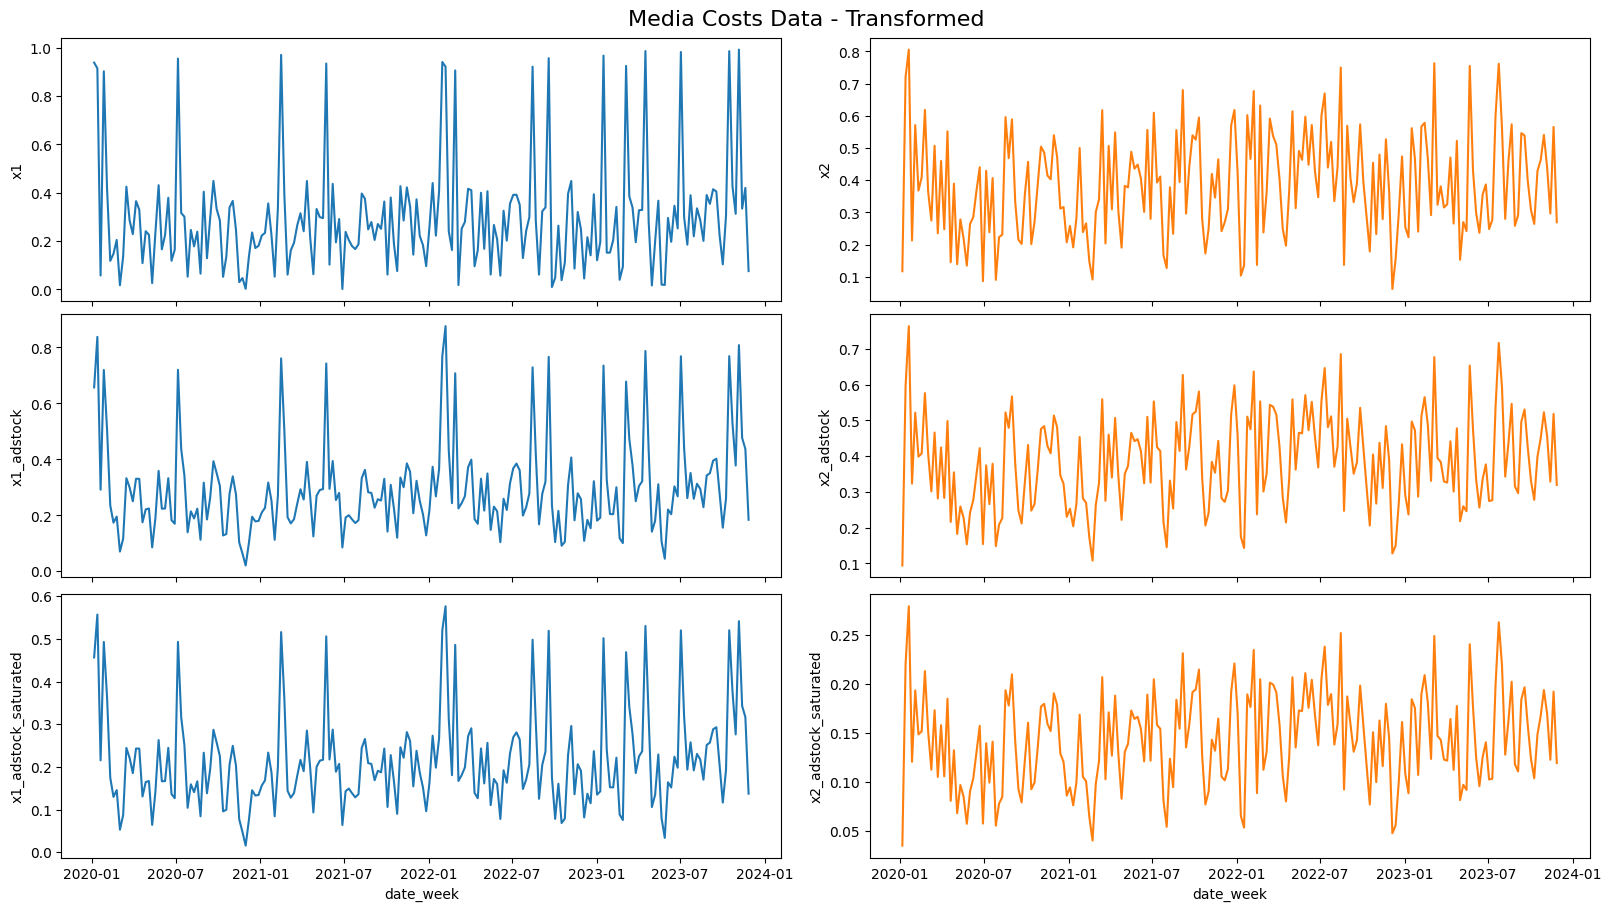

In [ ]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x1", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x2", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x1_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x2_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x1_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x2_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

ValueError: Could not interpret value `x4_adstock` for `y`. An entry with this name does not appear in `data`.

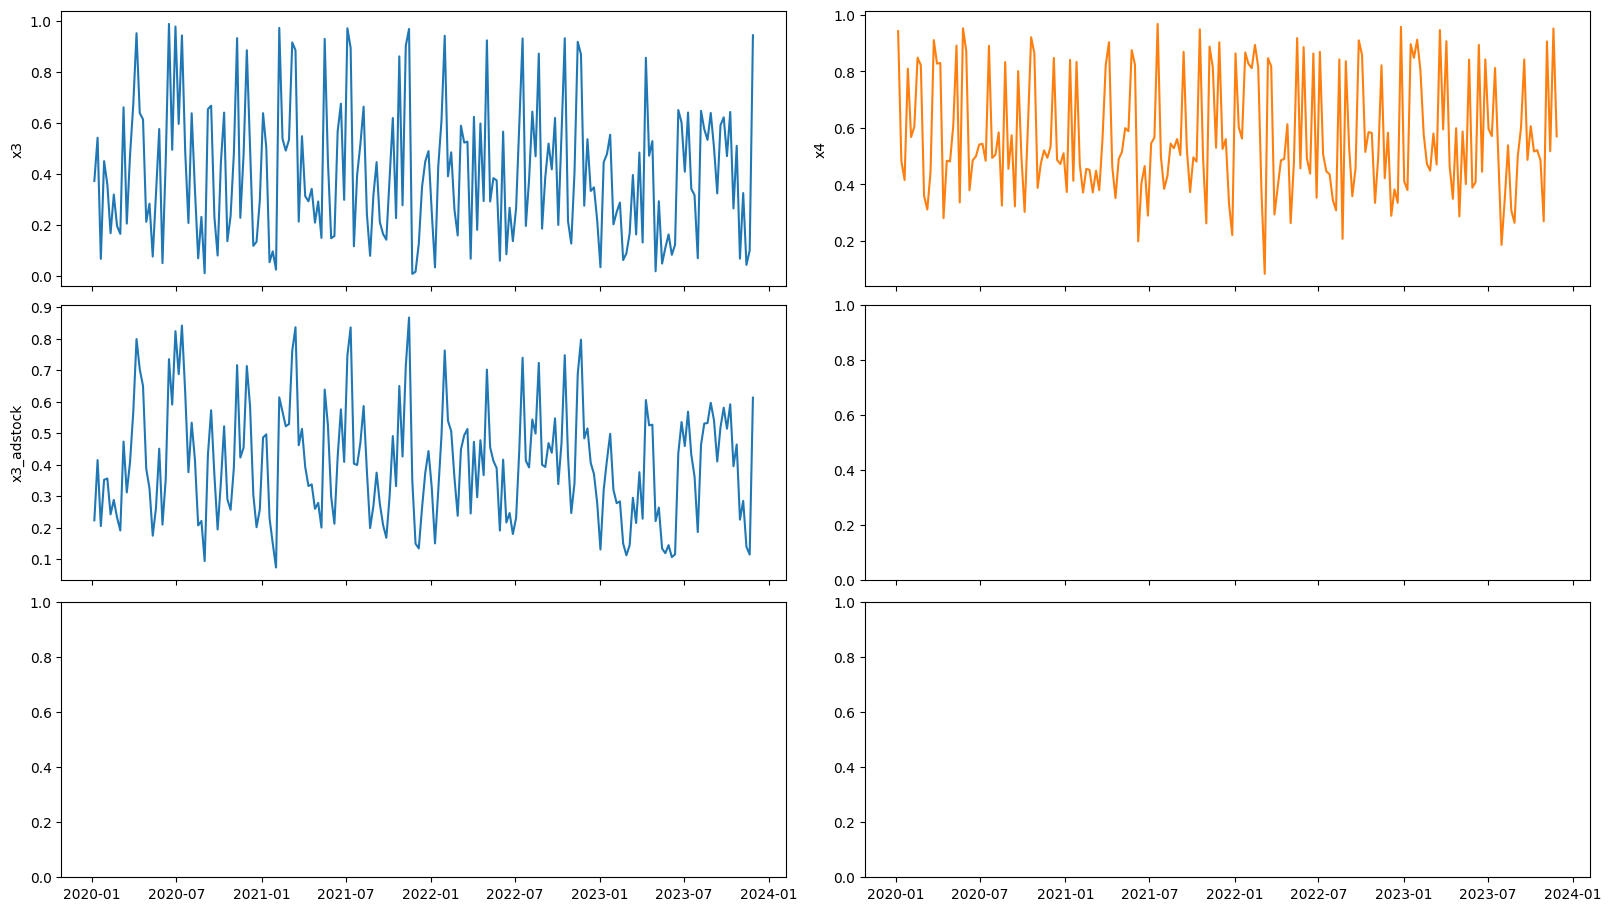

In [ ]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x3", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x4", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x3_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x4_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x3_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x4_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

ValueError: Could not interpret value `x5_adstock` for `y`. An entry with this name does not appear in `data`.

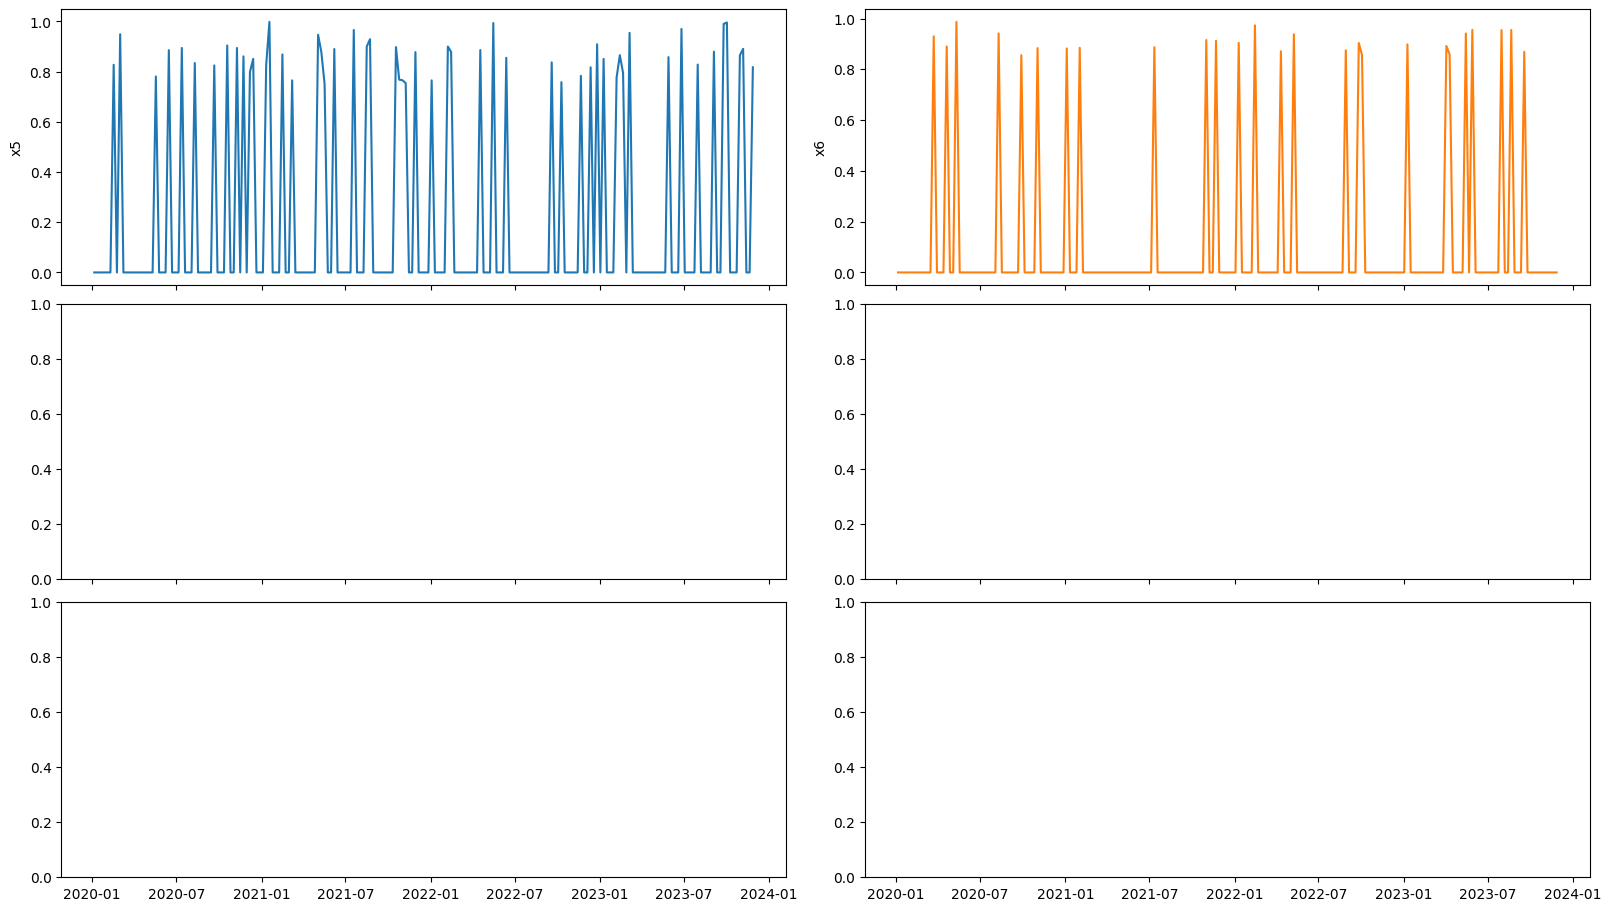

In [ ]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(16, 9), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="x5", data=df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="x6", data=df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="x5_adstock", data=df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="x6_adstock", data=df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="x5_adstock_saturated", data=df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="x6_adstock_saturated", data=df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed", fontsize=16);

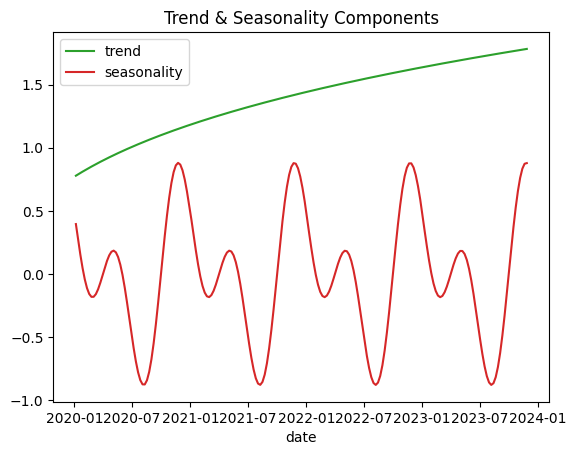

In [ ]:
df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

df["cs"] = -np.sin(2 * 2 * np.pi * df["dayofyear"] / 365.5)
df["cc"] = np.cos(1 * 2 * np.pi * df["dayofyear"] / 365.5)
df["seasonality"] = 0.5 * (df["cs"] + df["cc"])

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="trend", color="C2", label="trend", data=df, ax=ax)
sns.lineplot(
    x="date_week", y="seasonality", color="C3", label="seasonality", data=df, ax=ax
)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", xlabel="date", ylabel=None);

In [ ]:
df["event_1"] = (df["date_week"] == "2019-05-13").astype(float)
df["event_2"] = (df["date_week"] == "2020-09-14").astype(float)

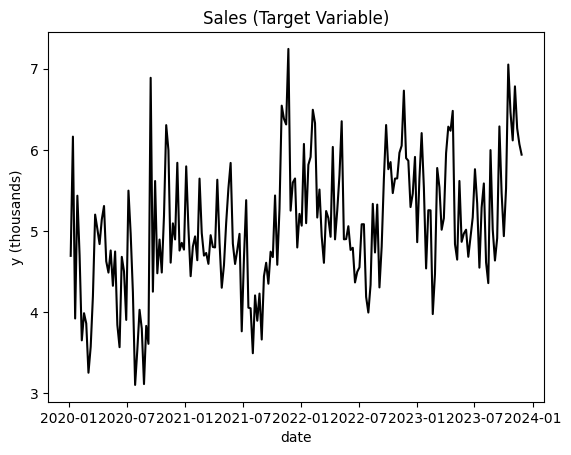

In [ ]:
df["intercept"] = 2.0
df["epsilon"] = rng.normal(loc=0.0, scale=0.25, size=n)

amplitude = 1#_00#0_000
beta_1 = 3.2
beta_2 = 2.0
beta_3 = 1.5
beta_4 = 2.0
beta_5 = 3.4
beta_6 = 2.0
betas = [beta_1, beta_2,beta_3,beta_4,beta_5,beta_6]


df["y"] = amplitude * (
    df["intercept"]
    + df["trend"]
    + df["seasonality"]
    + 1.5 * df["event_1"]
    + 2.5 * df["event_2"]
    + beta_1 * df["x1_adstock_saturated"]
    + beta_2 * df["x2_adstock_saturated"]
    + beta_3 * df["x3_adstock_saturated"]
    # + beta_4 * df["x4_adstock_saturated"]
    # + beta_5 * df["x5_adstock_saturated"]
    + beta_6 * df["x6_adstock_saturated"]
    + df["epsilon"]
)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=df, ax=ax)
ax.set(title="Sales (Target Variable)", xlabel="date", ylabel="y (thousands)");

In [ ]:
contribution_share_x1: float = (beta_1 * df["x1_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"]  + beta_6 * df["x6_adstock_saturated"]
    # beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"] + beta_4 * df["x4_adstock_saturated"] + beta_5 * df["x5_adstock_saturated"] + beta_6 * df["x6_adstock_saturated"]
).sum()

contribution_share_x2: float = (beta_2 * df["x2_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"]  + beta_6 * df["x6_adstock_saturated"]
    # beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"] + beta_4 * df["x4_adstock_saturated"] + beta_5 * df["x5_adstock_saturated"] + beta_6 * df["x6_adstock_saturated"]
).sum()

contribution_share_x3: float = (beta_3 * df["x3_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"]  + beta_6 * df["x6_adstock_saturated"]
    # beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"] + beta_4 * df["x4_adstock_saturated"] + beta_5 * df["x5_adstock_saturated"] + beta_6 * df["x6_adstock_saturated"]
).sum()

# contribution_share_x4: float = (beta_4 * df["x4_adstock_saturated"]).sum() / (
#     beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"] + beta_4 * df["x4_adstock_saturated"] + beta_5 * df["x5_adstock_saturated"] + beta_6 * df["x6_adstock_saturated"]
# ).sum()

# contribution_share_x5: float = (beta_5 * df["x5_adstock_saturated"]).sum() / (
#     beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"] + beta_4 * df["x4_adstock_saturated"] + beta_5 * df["x5_adstock_saturated"] + beta_6 * df["x6_adstock_saturated"]
# ).sum()

contribution_share_x6: float = (beta_6 * df["x6_adstock_saturated"]).sum() / (
    beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"]  + beta_6 * df["x6_adstock_saturated"]
    # beta_1 * df["x1_adstock_saturated"] + beta_2 * df["x2_adstock_saturated"] + beta_3 * df["x3_adstock_saturated"] + beta_4 * df["x4_adstock_saturated"] + beta_5 * df["x5_adstock_saturated"] + beta_6 * df["x6_adstock_saturated"]
).sum()

print(f"Contribution Share of x1: {contribution_share_x1:.2f}")
print(f"Contribution Share of x2: {contribution_share_x2:.2f}")
print(f"Contribution Share of x3: {contribution_share_x3:.2f}")
# print(f"Contribution Share of x4: {contribution_share_x4:.2f}")
# print(f"Contribution Share of x5: {contribution_share_x5:.2f}")
print(f"Contribution Share of x6: {contribution_share_x6:.2f}")

Contribution Share of x1: 0.41
Contribution Share of x2: 0.17
Contribution Share of x3: 0.34
Contribution Share of x6: 0.08


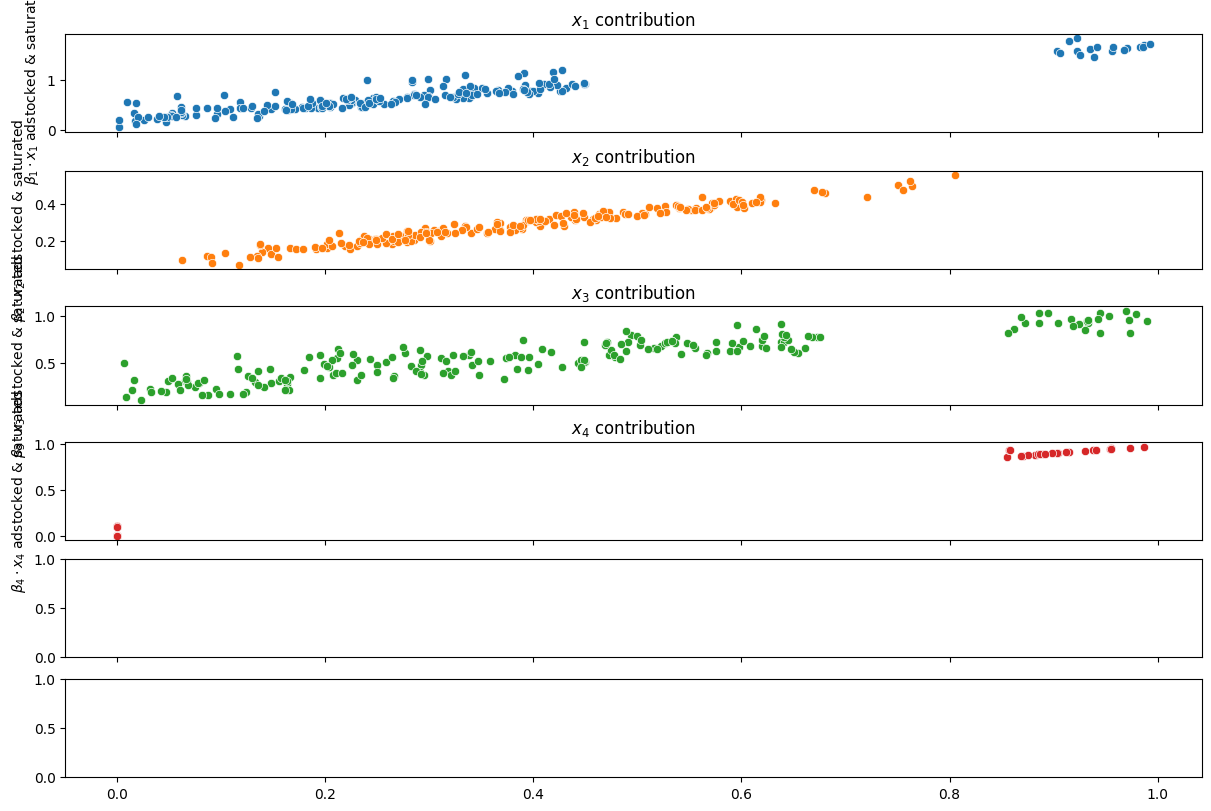

In [ ]:
fig, ax = plt.subplots(
    nrows=6, ncols=1, figsize=(12, 8), sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2",'x3','x6']):#enumerate(["x1", "x2",'x3','x4','x5','x6']):
    sns.scatterplot(
        x=df[x],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color=f"C{i}",
        ax=ax[i],
    )
    ax[i].set(
        title=f"$x_{i + 1}$ contribution",
        ylabel=f"$\\beta_{i + 1} \cdot x_{i + 1}$ adstocked & saturated",
        xlabel="x",
    )

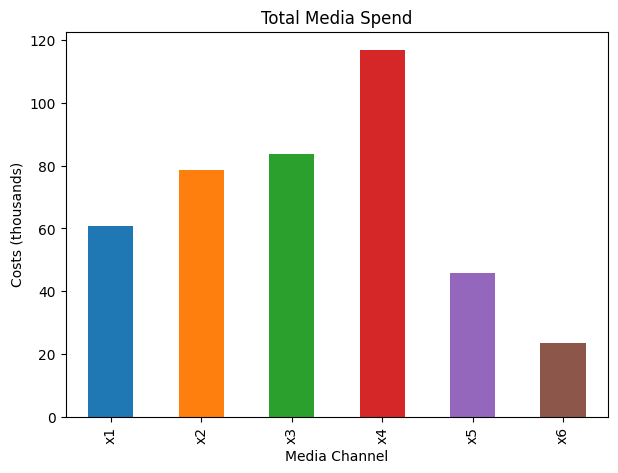

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
df[["x1", "x2",'x3','x4','x5','x6']].sum().plot(kind="bar", color=["C0", "C1","C2","C3", "C4","C5"], ax=ax)
ax.set(title="Total Media Spend", xlabel="Media Channel", ylabel="Costs (thousands)");

In [ ]:
roas_1 = (amplitude * beta_1 * df["x1_adstock_saturated"]).sum() / df["x1"].sum()
roas_2 = (amplitude * beta_2 * df["x2_adstock_saturated"]).sum() / df["x2"].sum()
roas_3 = (amplitude * beta_3 * df["x3_adstock_saturated"]).sum() / df["x3"].sum()
# roas_4 = (amplitude * beta_4 * df["x4_adstock_saturated"]).sum() / df["x4"].sum()
# roas_5 = (amplitude * beta_5 * df["x5_adstock_saturated"]).sum() / df["x5"].sum()
roas_6 = (amplitude * beta_6 * df["x6_adstock_saturated"]).sum() / df["x6"].sum()

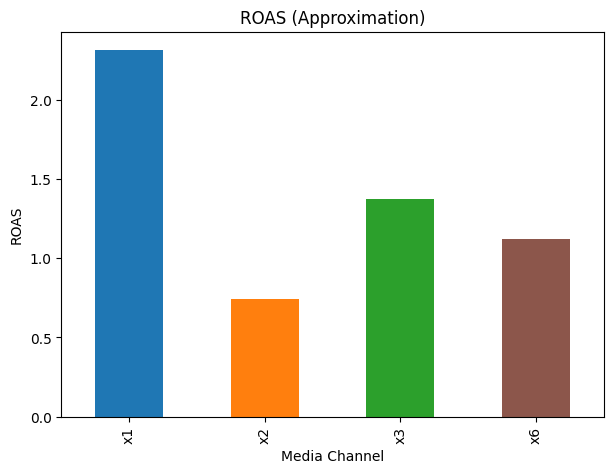

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
(
    pd.Series(data=[roas_1, roas_2,roas_3, roas_6], index=["x1", "x2",'x3','x6']).plot(
        kind="bar", color=["C0", "C1","C2","C5"]
    )
    # pd.Series(data=[roas_1, roas_2,roas_3, roas_4,roas_5, roas_6], index=["x1", "x2",'x3','x4','x5','x6']).plot(
    #     kind="bar", color=["C0", "C1","C2","C3", "C4","C5"]
    # )
)

ax.set(title="ROAS (Approximation)", xlabel="Media Channel", ylabel="ROAS");

In [ ]:
columns_to_keep = [
    "date_week",
    "y",
    "x1",
    "x2",
    "x3",
    # "x4",
    # "x5",
    "x6",
    "event_1",
    "event_2",
    "dayofyear",
]

data = df[columns_to_keep].copy()

data.head()

,date_week,y,x1,x2,x3,x6,event_1,event_2,dayofyear
0,2020-01-06,4.693177,0.938909,0.117422,0.372055,0.0,0.0,0.0,6
1,2020-01-13,6.163066,0.915058,0.721026,0.541900,0.0,0.0,0.0,13
2,2020-01-20,3.920891,0.057589,0.805671,0.065573,0.0,0.0,0.0,20
3,2020-01-27,5.434653,0.902865,0.212951,0.449700,0.0,0.0,0.0,27
4,2020-02-03,4.702432,0.418690,0.571229,0.358855,0.0,0.0,0.0,34


In [ ]:
data['x1'] = data['x1'] #*1_00#0_000
data['x2'] = data['x2'] #*1_00#0_000
data['x3'] = data['x3'] #*1_00#0_000
data['x4'] = data['x4'] #*1_00#0_000
data['x5'] = data['x5'] #*1_00#0_000
data['x6'] = data['x6'] #*1_00#0_000

In [ ]:
# trend feature
data["t"] = range(n)

data.head()

,date_week,y,x1,x2,x3,x6,event_1,event_2,dayofyear,t
0,2020-01-06,4.693177,0.938909,0.117422,0.372055,0.0,0.0,0.0,6,0
1,2020-01-13,6.163066,0.915058,0.721026,0.541900,0.0,0.0,0.0,13,1
2,2020-01-20,3.920891,0.057589,0.805671,0.065573,0.0,0.0,0.0,20,2
3,2020-01-27,5.434653,0.902865,0.212951,0.449700,0.0,0.0,0.0,27,3
4,2020-02-03,4.702432,0.418690,0.571229,0.358855,0.0,0.0,0.0,34,4


MODELING

In [ ]:
sampler_config= {"progressbar": True}

In [ ]:
mmm = DelayedSaturatedMMM(
    # model_config = my_model_config,
    sampler_config = sampler_config,
    date_column="date_week",
    # channel_columns=["x1", "x2",'x3','x4','x5','x6'],
    channel_columns=["x1", "x2",'x3','x6'],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=11,
    yearly_seasonality=2,
)

<ipython-input-36-91091620985f>:1: DeprecationWarning: The DelayedSaturatedMMM class is deprecated. Please use the MMM class instead.
  mmm = DelayedSaturatedMMM(


In [ ]:
mmm = MMM(
    date_column="date_week",
    adstock="geometric",
    saturation="logistic",
    channel_columns=["x1", "x2",'x3','x6'],
    control_columns=[
        "event_1",
        "event_2",
        "t",
    ],
    adstock_max_lag=11,
    yearly_seasonality=2,
)

In [ ]:
X = data.drop("y",axis=1)
y = data["y"]

In [ ]:
mmm.fit(X=X, y=y, target_accept=0.95, chains=2, draws=2000, tune=1000, random_seed=rng)

/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:518: FutureWarning: All coords are now mutable by default. coords_mutable will be removed in a future release.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymc/model/core.py:988: FutureWarning: Coords are now always mutable. Specifying `mutable` will raise an error in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymc/data.py:423: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pymc/data.py:423: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Output()

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data
	> fit_data

In [ ]:
# mmm.fit_result

In [ ]:
az.summary(
    data=mmm.fit_result,
        var_names=[
        "intercept",
        # "likelihood_sigma",
        # "beta_channel",
        # "alpha",
        # "lam",
        "gamma_control",
        "gamma_fourier",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.373,0.022,0.333,0.413,0.000,0.000,2205.0,2236.0,1.0
gamma_control[event_1],0.059,1.985,-3.639,3.766,0.033,0.029,3546.0,2901.0,1.0
gamma_control[event_2],0.374,0.036,0.310,0.445,0.001,0.000,4058.0,3008.0,1.0
gamma_control[t],0.001,0.000,0.001,0.001,0.000,0.000,3030.0,2898.0,1.0
gamma_fourier[sin_order_1],0.002,0.004,-0.004,0.010,0.000,0.000,3510.0,2857.0,1.0
gamma_fourier[cos_order_1],0.065,0.004,0.058,0.071,0.000,0.000,3627.0,3070.0,1.0
gamma_fourier[sin_order_2],-0.068,0.004,-0.075,-0.061,0.000,0.000,2945.0,2936.0,1.0
gamma_fourier[cos_order_2],0.001,0.004,-0.006,0.008,0.000,0.000,4547.0,2951.0,1.0


In [ ]:
mmm.sample_posterior_predictive(X, extend_idata=True, combined=True)

Output()

<xarray.Dataset>
Dimensions:  (date: 204, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2020-01-06 2020-01-13 ... 2023-11-27
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    y        (date, sample) float64 5.133 4.928 4.907 ... 6.547 5.612 6.247
Attributes:
    created_at:                 2024-07-16T23:57:41.419365+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

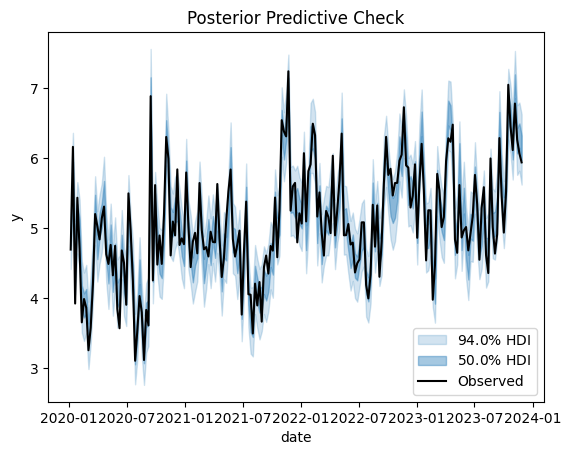

In [ ]:
mmm.plot_posterior_predictive(original_scale=True);

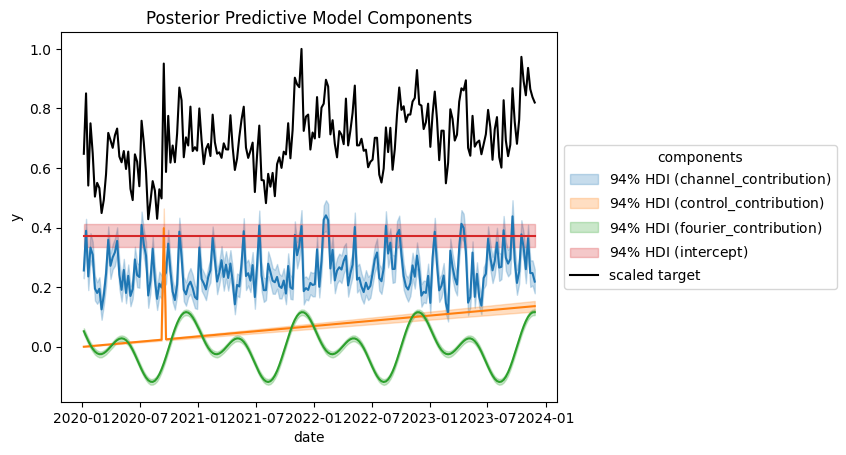

In [ ]:
mmm.plot_components_contributions();

In [ ]:
get_mean_contributions_over_time_df = mmm.compute_mean_contributions_over_time(
    original_scale=True
)

get_mean_contributions_over_time_df.head()

,x1,x2,x3,x6,event_1,event_2,t,yearly_seasonality,intercept
date,,,,,,,,,
2020-01-06,1.484376,0.095206,0.275149,0.0,0.0,0.0,0.000000,0.376317,2.705281
2020-01-13,1.774065,0.506618,0.538921,0.0,0.0,0.0,0.004864,0.256260,2.705281
2020-01-20,0.764669,0.595271,0.349260,0.0,0.0,0.0,0.009728,0.141423,2.705281
2020-01-27,1.603017,0.292279,0.516548,0.0,0.0,0.0,0.014592,0.037830,2.705281
2020-02-03,1.235215,0.460325,0.543481,0.0,0.0,0.0,0.019456,-0.049428,2.705281


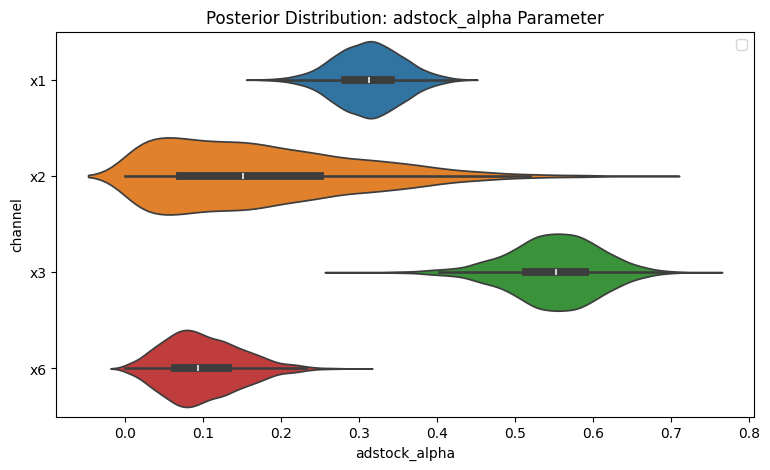

In [ ]:
fig = mmm.plot_channel_parameter(param_name="adstock_alpha", figsize=(9, 5))
ax = fig.axes[0]
# ax.axvline(x=alpha1, color="C0", linestyle="--", label=r"$\alpha_1$")
# ax.axvline(x=alpha2, color="C1", linestyle="--", label=r"$\alpha_2$")
ax.legend(loc="upper right");

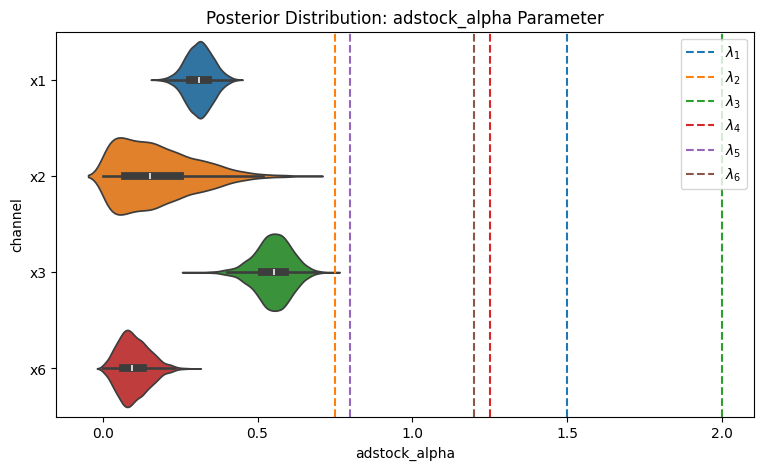

In [ ]:
fig = mmm.plot_channel_parameter(param_name="adstock_alpha", figsize=(9, 5))
ax = fig.axes[0]
ax.axvline(x=lam1, color="C0", linestyle="--", label=r"$\lambda_1$")
ax.axvline(x=lam2, color="C1", linestyle="--", label=r"$\lambda_2$")
ax.axvline(x=lam3, color="C2", linestyle="--", label=r"$\lambda_3$")
ax.axvline(x=lam4, color="C3", linestyle="--", label=r"$\lambda_4$")
ax.axvline(x=lam5, color="C4", linestyle="--", label=r"$\lambda_5$")
ax.axvline(x=lam6, color="C5", linestyle="--", label=r"$\lambda_6$")
ax.legend(loc="upper right");

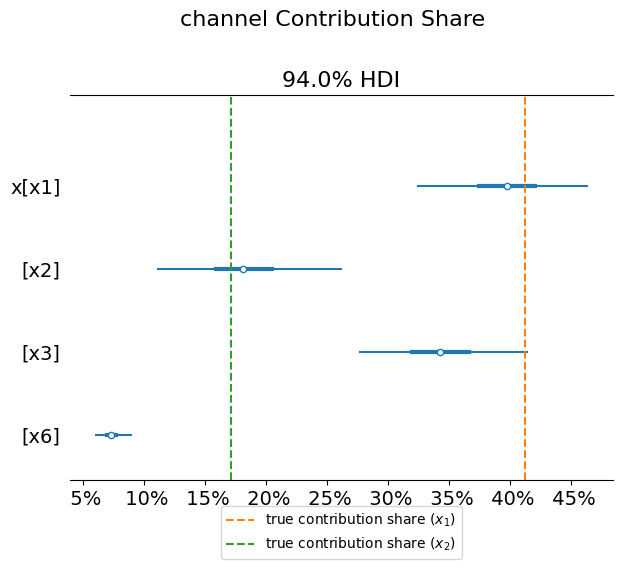

In [ ]:
fig = mmm.plot_channel_contribution_share_hdi(figsize=(7, 5))
ax = fig.axes[0]
ax.axvline(
    x=contribution_share_x1,
    color="C1",
    linestyle="--",
    label="true contribution share ($x_1$)",
)
ax.axvline(
    x=contribution_share_x2,
    color="C2",
    linestyle="--",
    label="true contribution share ($x_2$)",
)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=1);

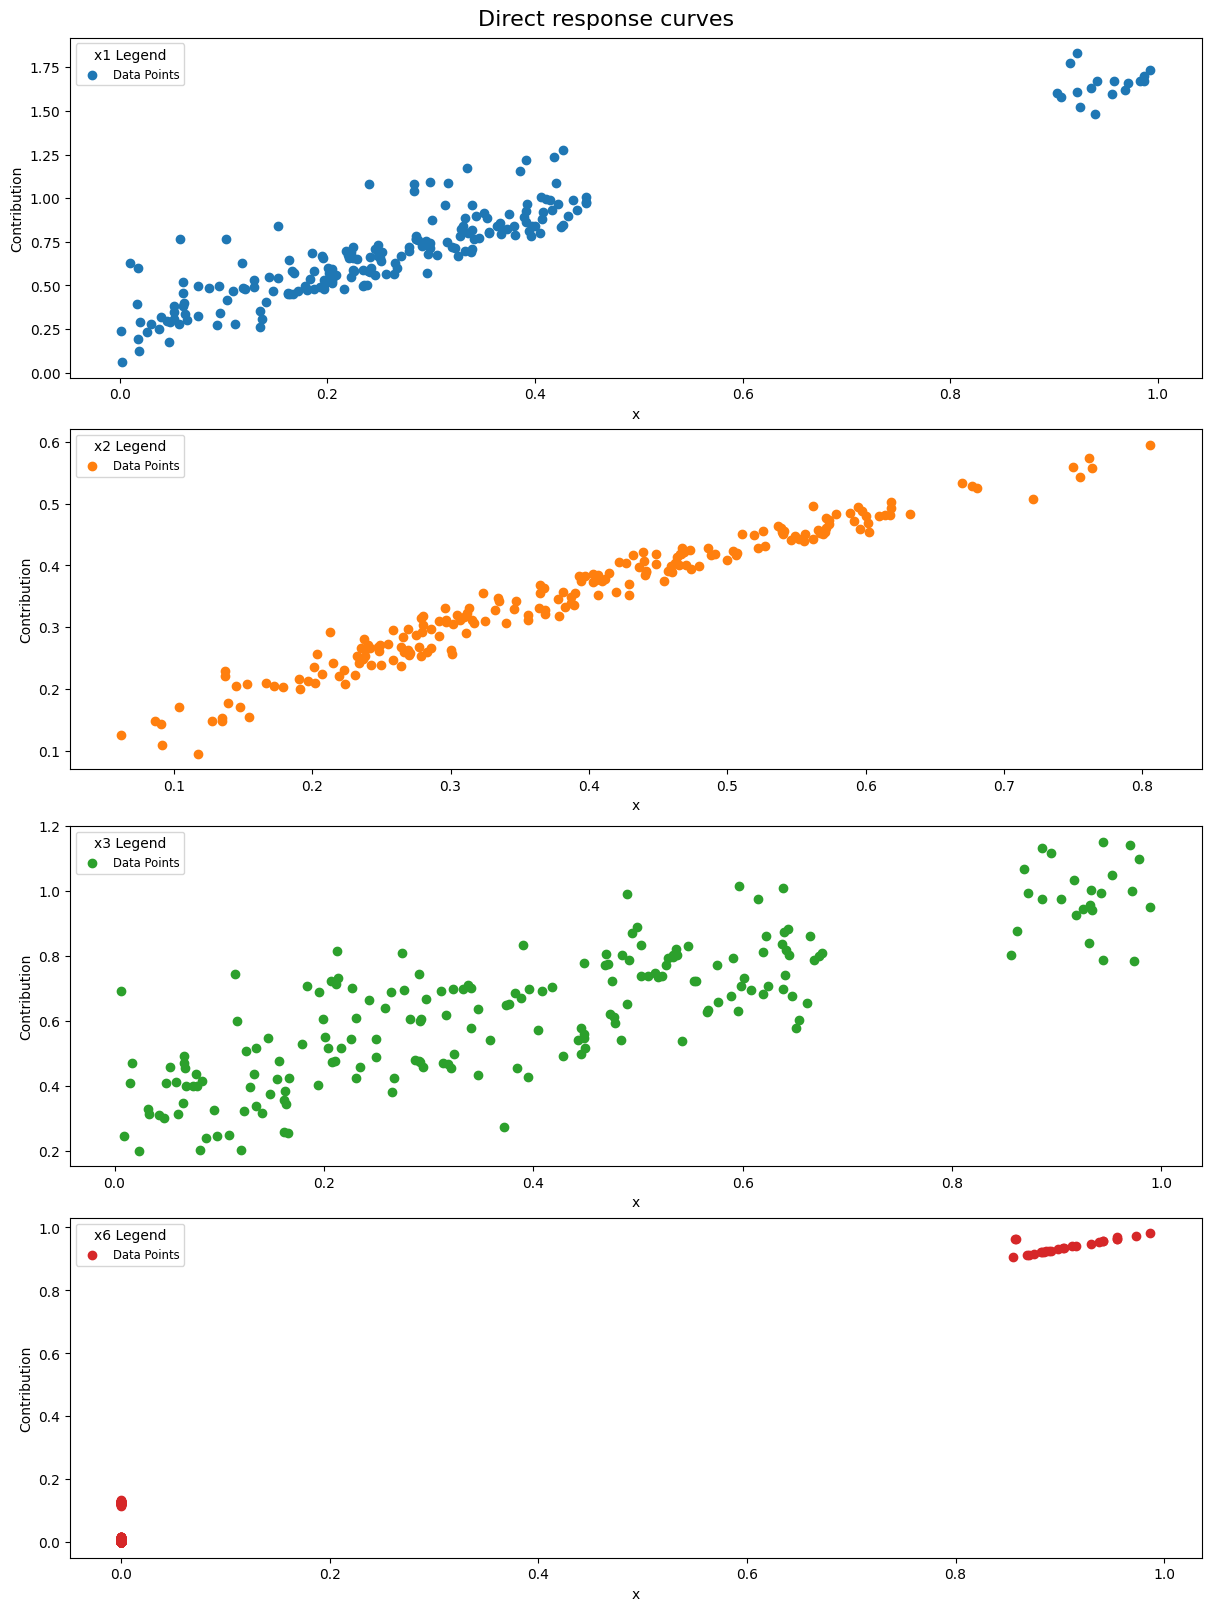

In [ ]:
fig = mmm.plot_direct_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];

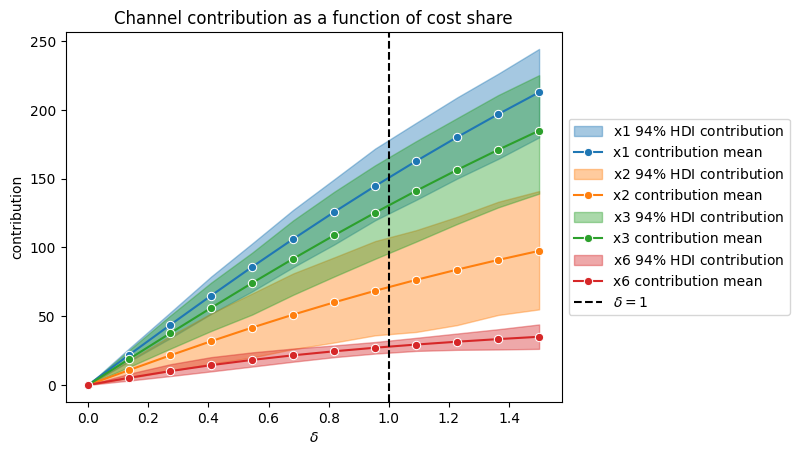

In [ ]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12);

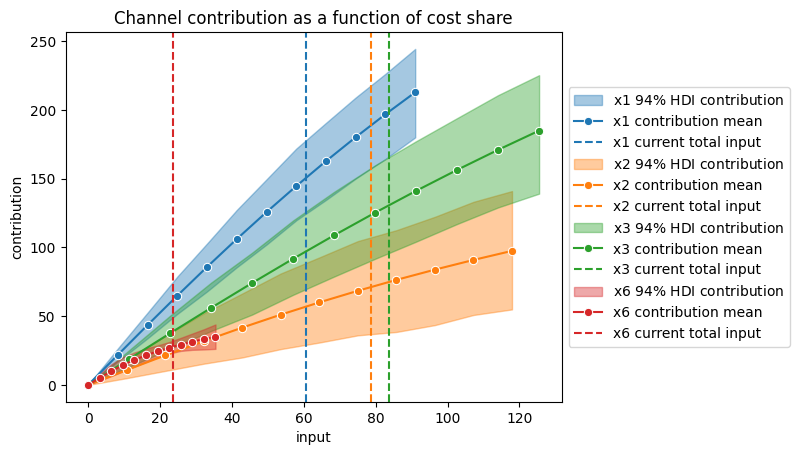

In [ ]:
mmm.plot_channel_contributions_grid(start=0, stop=1.5, num=12, absolute_xrange=True);

KeyError: 'x4_adstock_saturated'

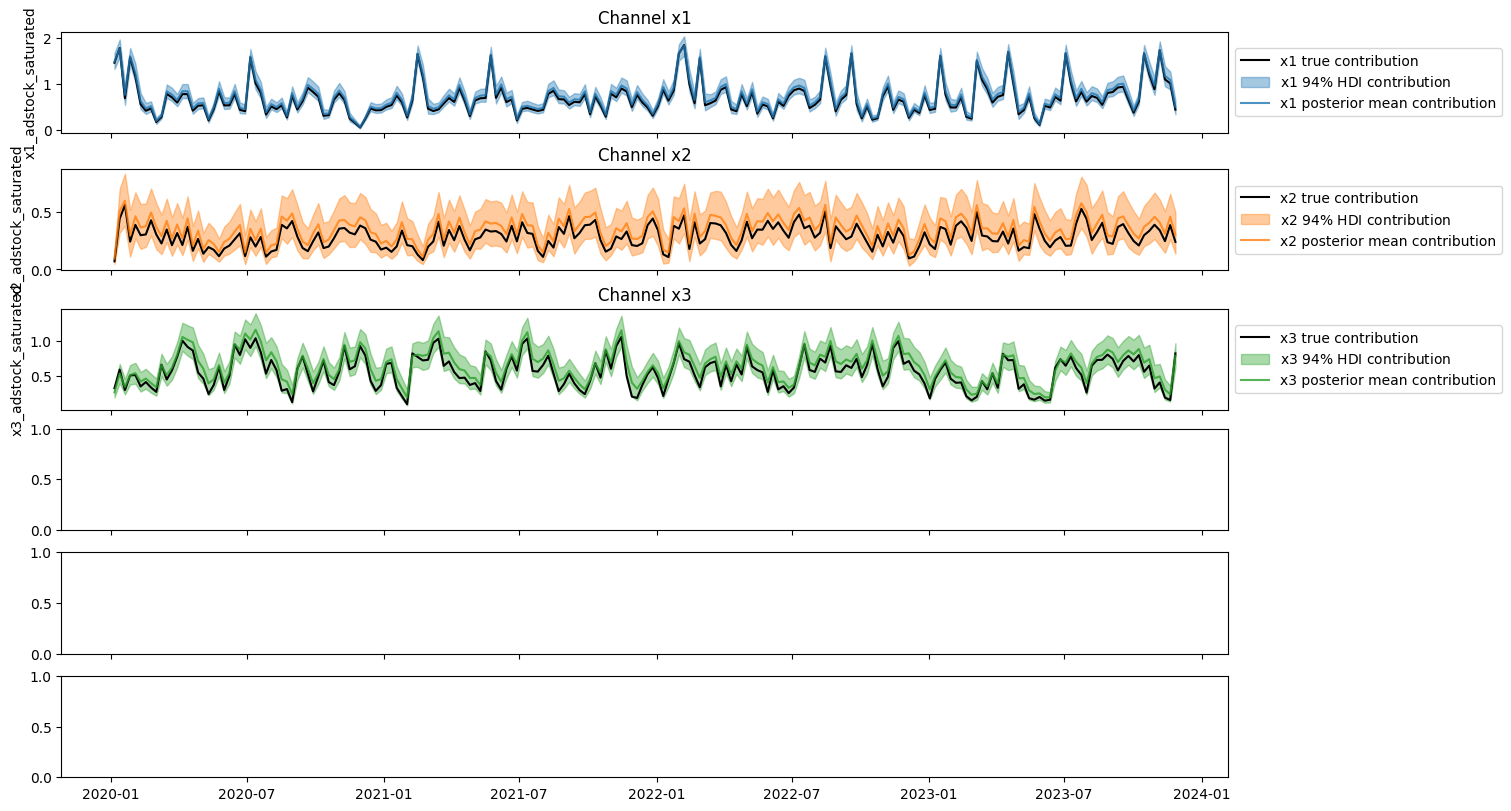

In [ ]:
channels_contribution_original_scale = mmm.compute_channel_contribution_original_scale()
channels_contribution_original_scale_hdi = az.hdi(
    ary=channels_contribution_original_scale
)

fig, ax = plt.subplots(
    nrows=6, figsize=(15, 8), ncols=1, sharex=True, sharey=False, layout="constrained"
)

for i, x in enumerate(["x1", "x2",'x3','x4','x5','x6']):
    # Estimate true contribution in the original scale from the data generating process
    sns.lineplot(
        x=df["date_week"],
        y=amplitude * betas[i] * df[f"{x}_adstock_saturated"],
        color="black",
        label=f"{x} true contribution",
        ax=ax[i],
    )
    # HDI estimated contribution in the original scale
    ax[i].fill_between(
        x=df["date_week"],
        y1=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 0],
        y2=channels_contribution_original_scale_hdi.sel(channel=x)["x"][:, 1],
        color=f"C{i}",
        label=f"{x} $94\%$ HDI contribution",
        alpha=0.4,
    )
    # Mean estimated contribution in the original scale
    sns.lineplot(
        x=df["date_week"],
        y=get_mean_contributions_over_time_df[x].to_numpy(),
        color=f"C{i}",
        label=f"{x} posterior mean contribution",
        alpha=0.8,
        ax=ax[i],
    )
    ax[i].legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax[i].set(title=f"Channel {x}")

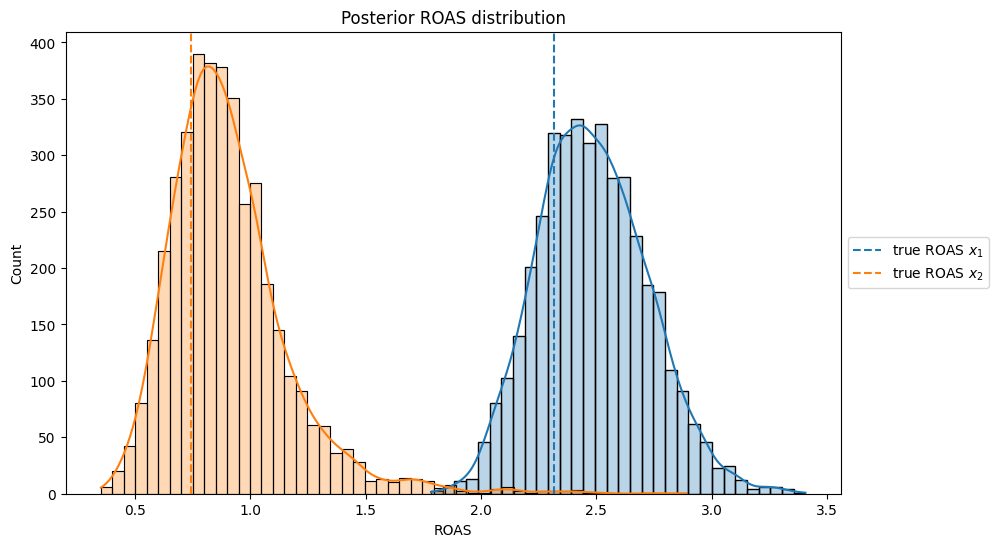

In [ ]:
channel_contribution_original_scale = mmm.compute_channel_contribution_original_scale()

roas_samples = (
    channel_contribution_original_scale.stack(sample=("chain", "draw")).sum("date")
    # / data[["x1", "x2",'x3','x4','x5','x6']].sum().to_numpy()[..., None]
    / data[["x1", "x2",'x3','x6']].sum().to_numpy()[..., None]
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="x1").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
sns.histplot(
    roas_samples.sel(channel="x2").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax
)
ax.axvline(x=roas_1, color="C0", linestyle="--", label=r"true ROAS $x_{1}$")
ax.axvline(x=roas_2, color="C1", linestyle="--", label=r"true ROAS $x_{2}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

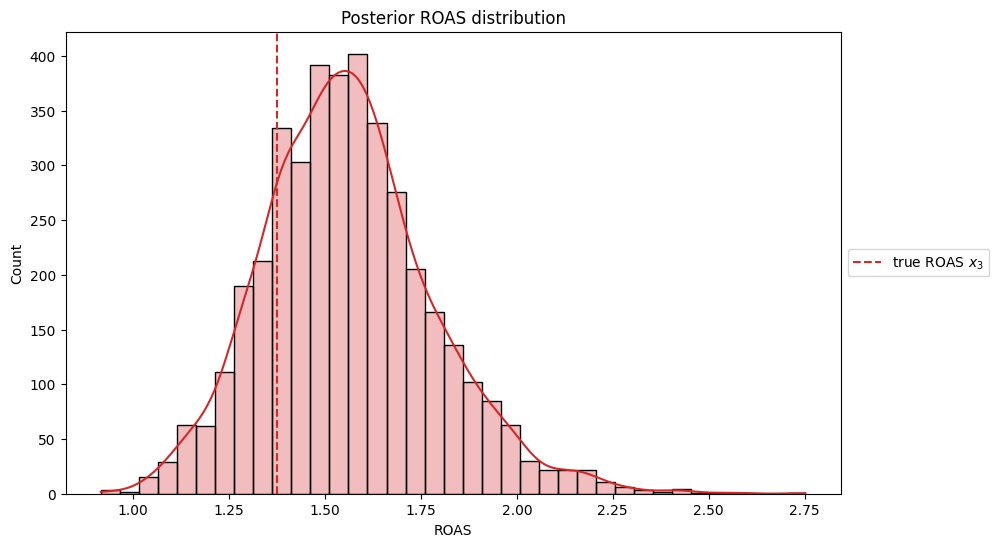

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    roas_samples.sel(channel="x3").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax, color="C3"
)
sns.histplot(
    # roas_samples.sel(channel="x4").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax, color="C4"
)
ax.axvline(x=roas_3, color="C3", linestyle="--", label=r"true ROAS $x_{3}$")
# ax.axvline(x=roas_4, color="C4", linestyle="--", label=r"true ROAS $x_{4}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

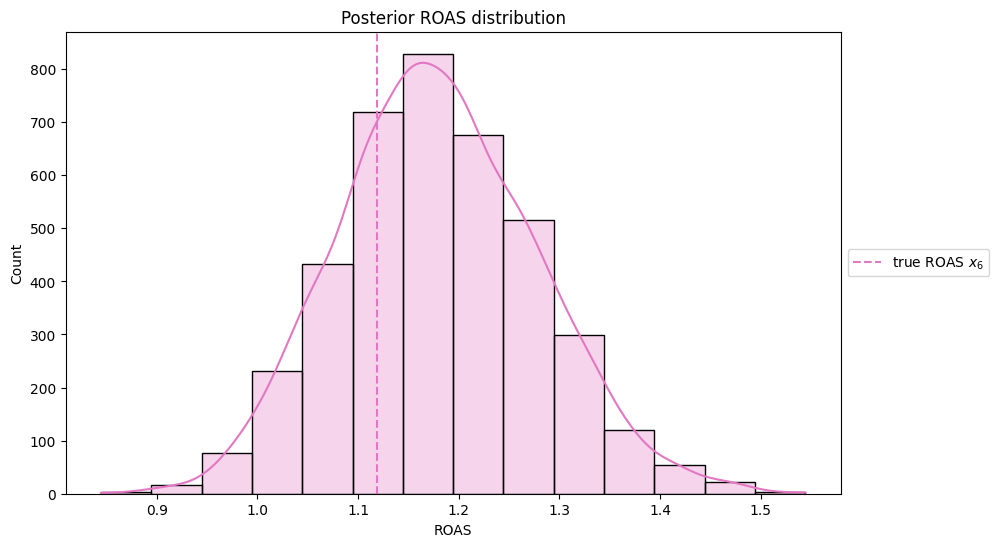

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    # roas_samples.sel(channel="x5").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax, color="C5"
)
sns.histplot(
    roas_samples.sel(channel="x6").to_numpy(), binwidth=0.05, alpha=0.3, kde=True, ax=ax, color="C6"
)
# ax.axvline(x=roas_5, color="C5", linestyle="--", label=r"true ROAS $x_{5}$")
ax.axvline(x=roas_6, color="C6", linestyle="--", label=r"true ROAS $x_{6}$")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Posterior ROAS distribution", xlabel="ROAS");

In [ ]:
last_date = X["date_week"].max()

# New dates starting from last in dataset
n_new = 5
new_dates = pd.date_range(start=last_date, periods=1 + n_new, freq="W-MON")[1:]

X_out_of_sample = pd.DataFrame({
    "date_week": new_dates,
})

# Same channel spends as last day
X_out_of_sample["x1"] = X["x1"].iloc[-1]
X_out_of_sample["x2"] = X["x2"].iloc[-1]
X_out_of_sample["x3"] = X["x3"].iloc[-1]
# X_out_of_sample["x4"] = X["x4"].iloc[-1]
# X_out_of_sample["x5"] = X["x5"].iloc[-1]
X_out_of_sample["x6"] = X["x6"].iloc[-1]
# Other features
X_out_of_sample["event_1"] = 0
X_out_of_sample["event_2"] = 0

X_out_of_sample["t"] = range(len(X), len(X) + n_new)

X_out_of_sample

,date_week,x1,x2,x3,x6,event_1,event_2,t
0,2023-12-04,0.075799,0.269621,0.944538,0.0,0,0,204
1,2023-12-11,0.075799,0.269621,0.944538,0.0,0,0,205
2,2023-12-18,0.075799,0.269621,0.944538,0.0,0,0,206
3,2023-12-25,0.075799,0.269621,0.944538,0.0,0,0,207
4,2024-01-01,0.075799,0.269621,0.944538,0.0,0,0,208


In [ ]:
y_out_of_sample = mmm.sample_posterior_predictive(X_pred=X_out_of_sample, extend_idata=False)

y_out_of_sample

Output()

<xarray.Dataset>
Dimensions:  (date: 5, sample: 4000)
Coordinates:
  * date     (date) datetime64[ns] 2023-12-04 2023-12-11 ... 2024-01-01
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1 1 1 1
  * draw     (sample) int64 0 1 2 3 4 5 6 ... 1993 1994 1995 1996 1997 1998 1999
Data variables:
    y        (date, sample) float64 5.47 5.949 5.817 5.94 ... 5.56 5.718 5.673
Attributes:
    created_at:                 2024-07-17T00:01:35.482481+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

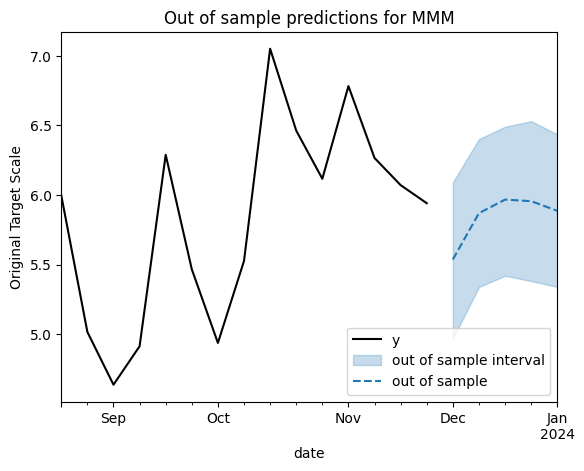

In [ ]:
def plot_in_sample(X, y, ax, n_points: int = 15):
    (
        y.to_frame()
        .set_index(X["date_week"])
        .iloc[-n_points:]
        .plot(ax=ax, color="black", label="actuals")
    )

def plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax, color, label):
    y_out_of_sample_groupby = y_out_of_sample["y"].to_series().groupby("date")

    lower, upper = quantiles = [0.025, 0.975]
    conf = y_out_of_sample_groupby.quantile(quantiles).unstack()
    ax.fill_between(
        X_out_of_sample["date_week"].dt.to_pydatetime(),
        conf[lower],
        conf[upper],
        alpha=0.25,
        color=color,
        label=f"{label} interval",
    )

    mean = y_out_of_sample_groupby.mean()
    mean.plot(ax=ax, label=label, color=color, linestyle="--")
    ax.set(
        ylabel="Original Target Scale",
        title="Out of sample predictions for MMM"
    )

    return ax

_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax)
plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax=ax, label="out of sample", color="C0")
ax.legend();

In [ ]:
y_out_of_sample_with_adstock = mmm.sample_posterior_predictive(
    X_pred=X_out_of_sample,
    extend_idata=False,
    include_last_observations=True
)

Output()

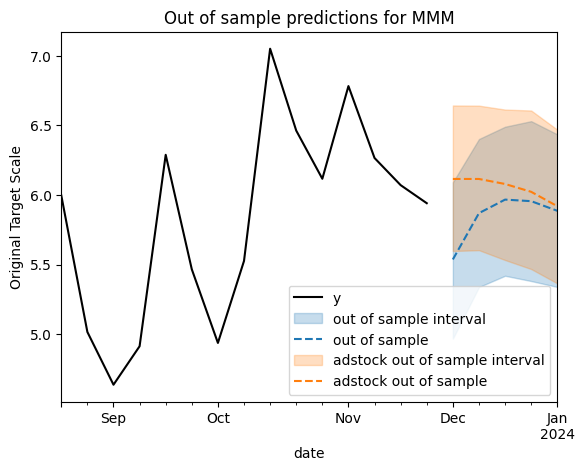

In [ ]:
_, ax = plt.subplots()
plot_in_sample(X, y, ax=ax)
plot_out_of_sample(X_out_of_sample, y_out_of_sample, ax=ax, label="out of sample", color="C0")
plot_out_of_sample(X_out_of_sample, y_out_of_sample_with_adstock, ax=ax, label="adstock out of sample", color="C1")
ax.legend();

# Budgeting

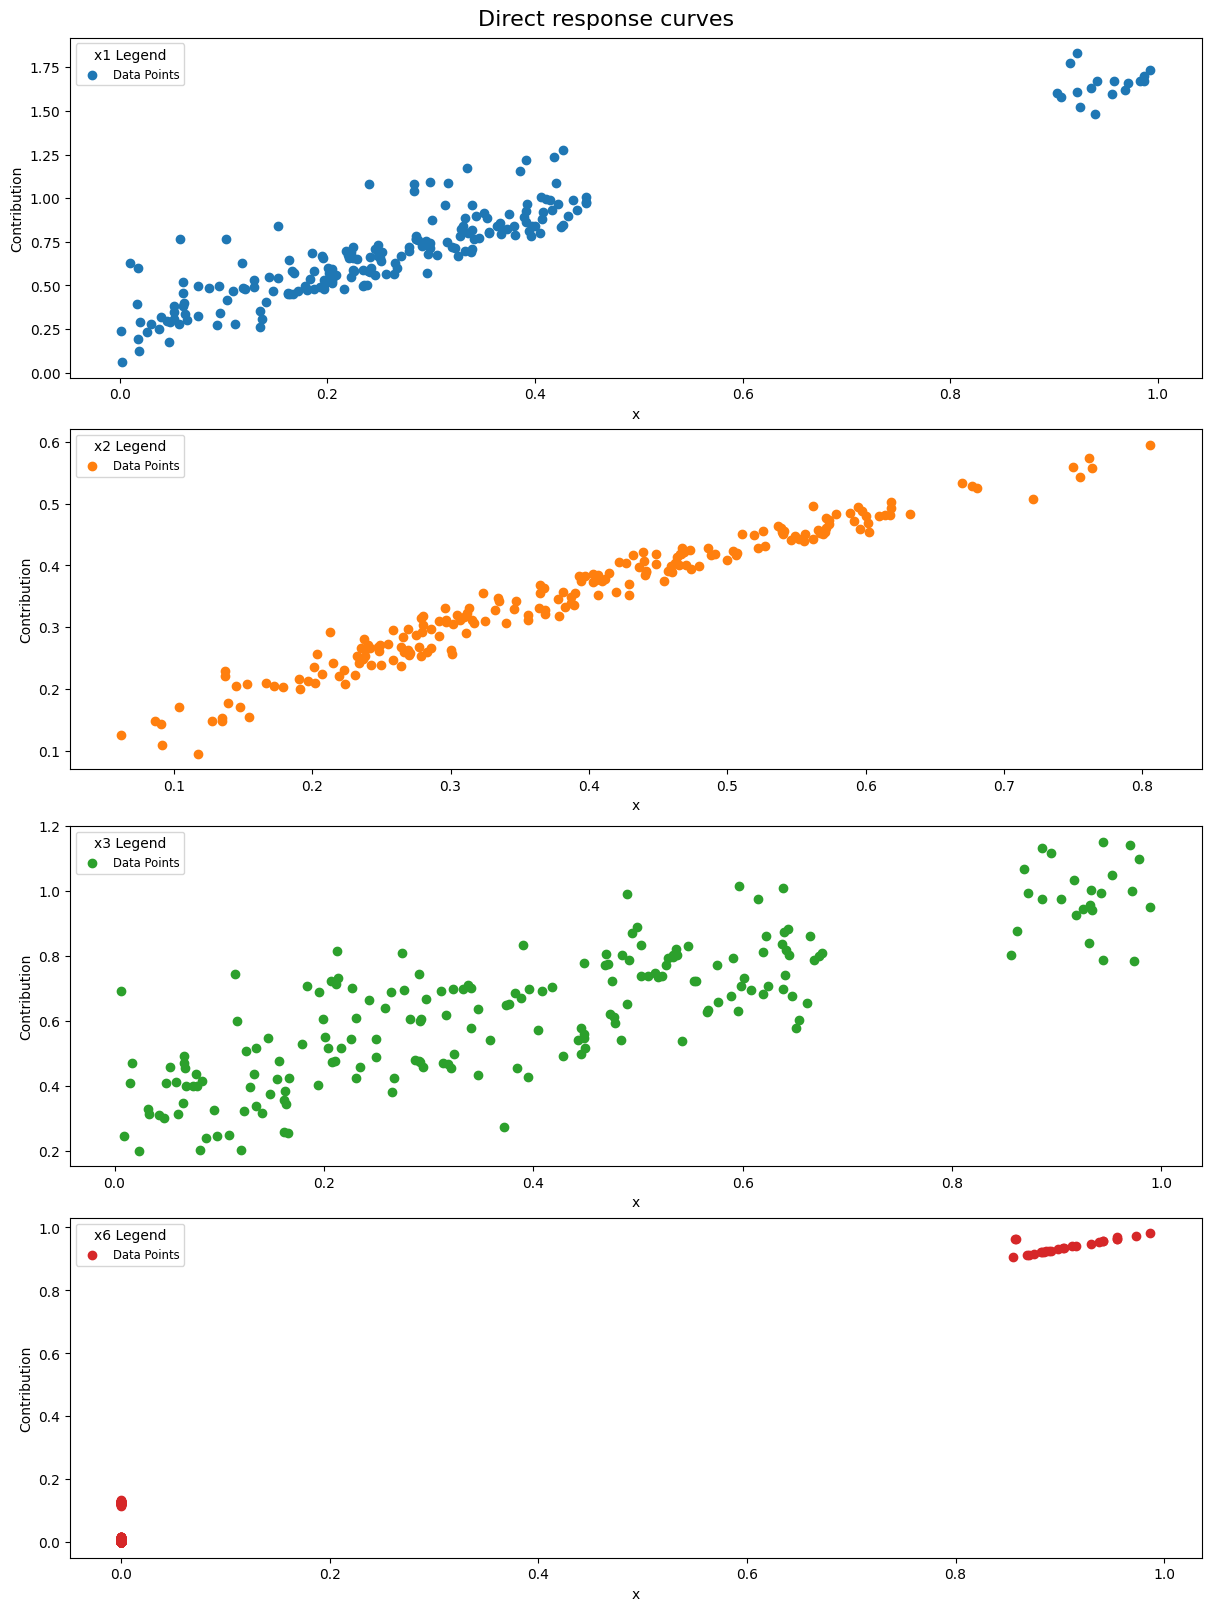

In [ ]:
fig = mmm.plot_direct_contribution_curves()
[ax.set(xlabel="x") for ax in fig.axes];

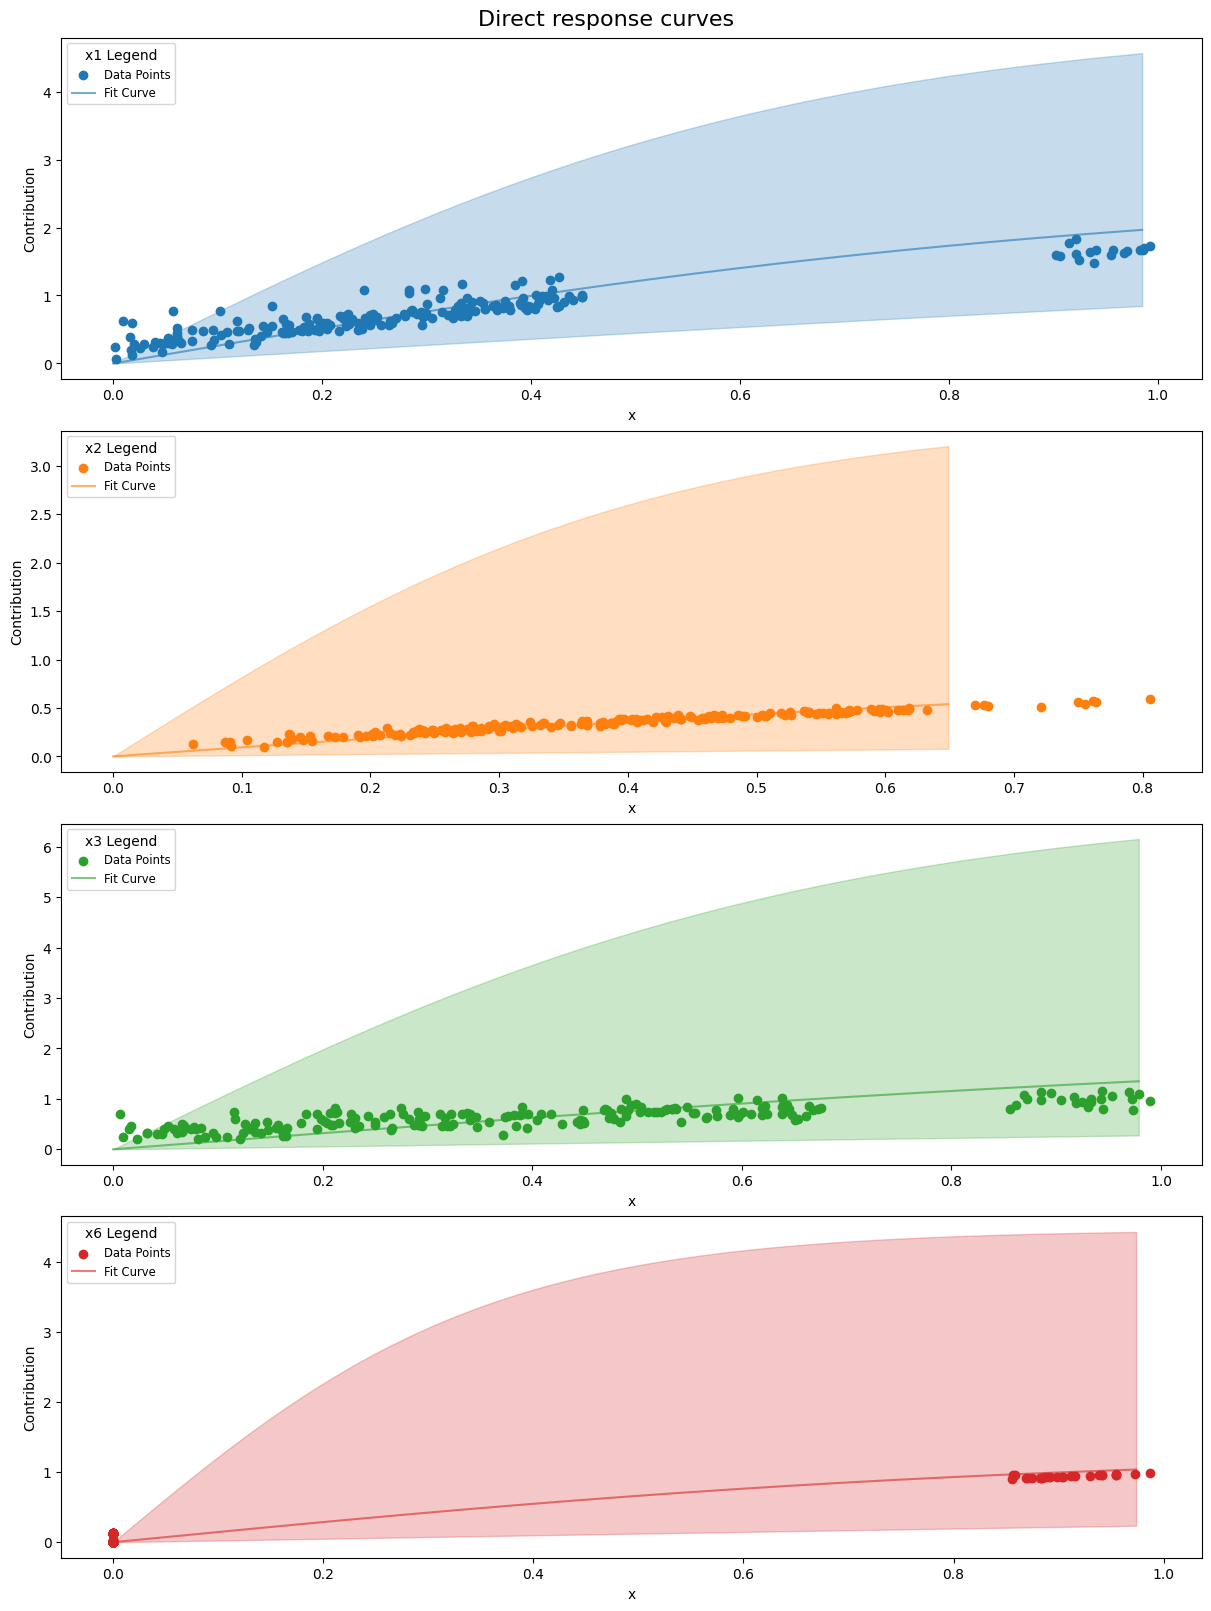

In [ ]:
fig = mmm.plot_direct_contribution_curves(show_fit=True)
[ax.set(xlabel="x") for ax in fig.axes];

In [ ]:
# fig = mmm.plot_direct_contribution_curves(show_fit=True, method="michaelis-menten")
# [ax.set(xlabel="x") for ax in fig.axes];

In [ ]:
total_budget = 10  # Imagine is 5K or 5M
# Define your channels
channels = ["x1", "x2","x3","x6"]
# The initial split per channel
budget_per_channel = total_budget / len(channels)
# Initial budget per channel as dictionary.
initial_budget_dict = {channel: budget_per_channel for channel in channels}
# bounds for each channel
min_budget, max_budget = 0.5, 5
budget_bounds = {channel: [min_budget, max_budget] for channel in channels}

In [ ]:
response = mmm.allocate_budget_to_maximize_response(
    budget=total_budget,
    num_days=1,
    time_granularity="weekly",
    budget_bounds=budget_bounds,
)

/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:1993: UserWarning: Using default equality constraint: The sum of all budgets should be equal to the total budget.
  self.optimal_allocation_dict, _ = allocator.allocate_budget(


/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:2126: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x7c43bb8615a0> starts with '_'. It is thus excluded from the legend.
  ax.legend(bars, labels)
/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:2126: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x7c43b42ae0b0> starts with '_'. It is thus excluded from the legend.
  ax.legend(bars, labels)


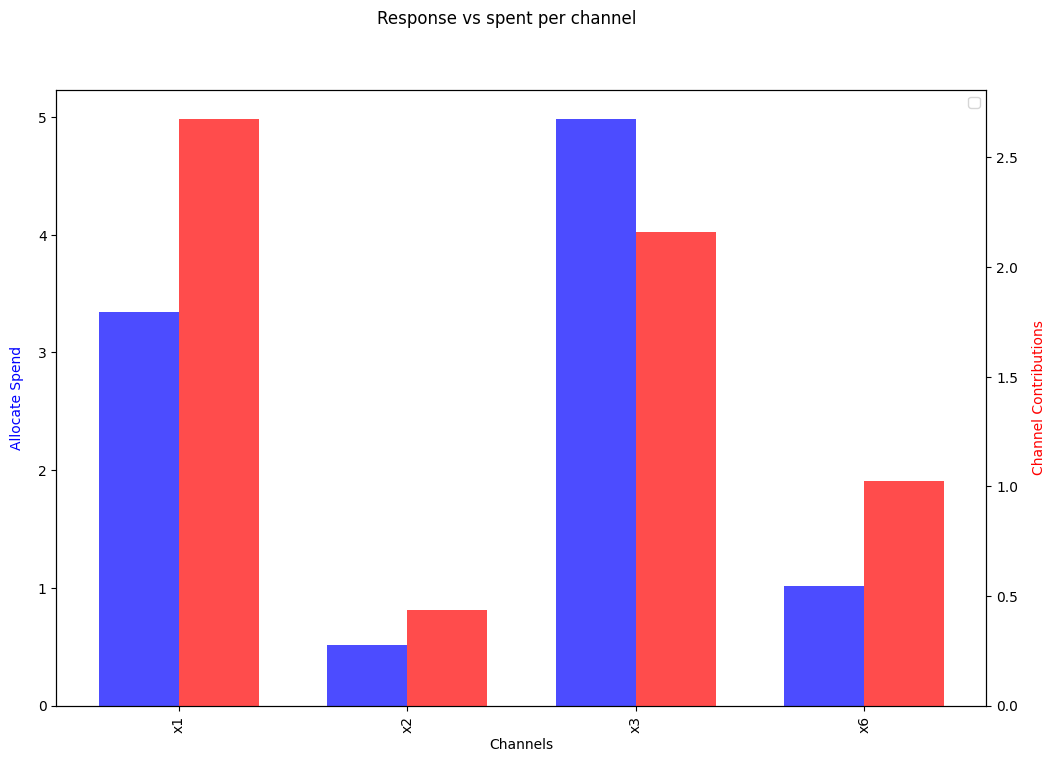

In [ ]:
fig, ax = mmm.plot_budget_allocation(samples=response, figsize=(12, 8))
fig.suptitle("Response vs spent per channel");

In [ ]:
print(mmm.optimal_allocation_dict)

{'x1': 3.366915525506541, 'x2': 0.6399977861740517, 'x3': 5.037382486679317, 'x6': 1.0304691749987258}


In [ ]:
print(mmm.)

In [ ]:
tmp_response = mmm.allocate_budget_to_maximize_response(
    budget=total_budget *  0.8,
    num_days=1,
    time_granularity="weekly",
    budget_bounds=budget_bounds,
)

/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:1993: UserWarning: Using default equality constraint: The sum of all budgets should be equal to the total budget.
  self.optimal_allocation_dict, _ = allocator.allocate_budget(


/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:2126: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x7c43b8a986d0> starts with '_'. It is thus excluded from the legend.
  ax.legend(bars, labels)
/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:2126: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x7c43bd9bcaf0> starts with '_'. It is thus excluded from the legend.
  ax.legend(bars, labels)


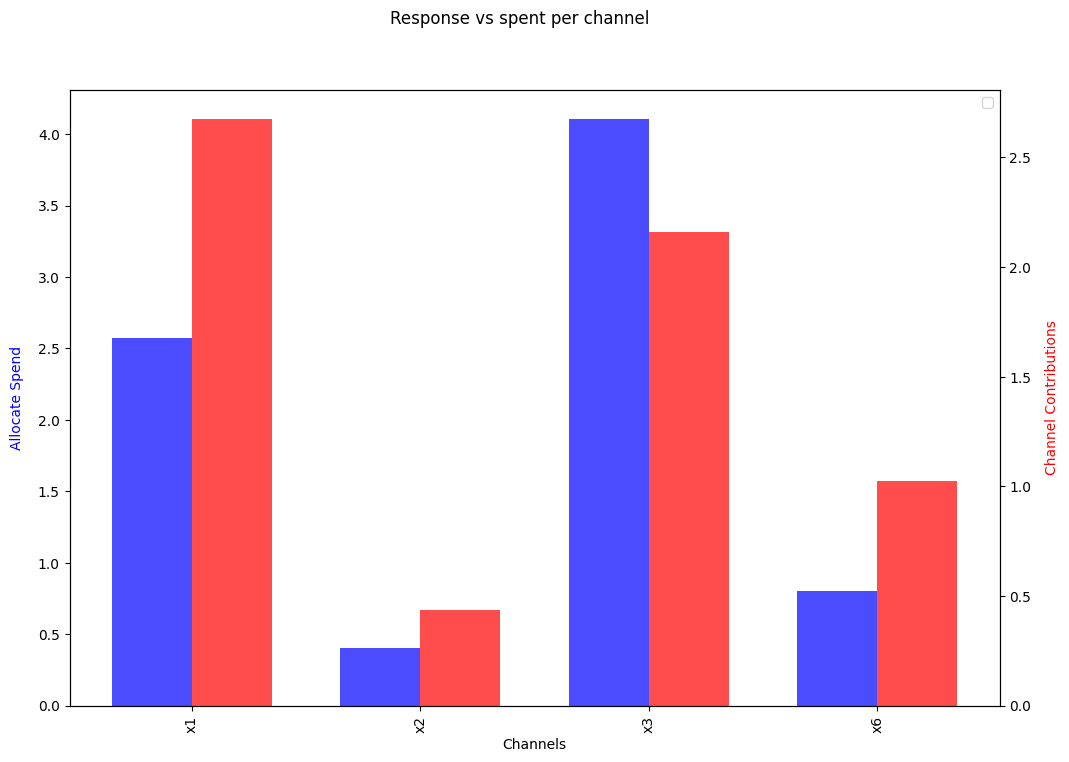

In [ ]:
fig, ax = mmm.plot_budget_allocation(samples=response, figsize=(12, 8))
fig.suptitle("Response vs spent per channel");

In [ ]:
print(mmm.optimal_allocation_dict)

{'x1': 2.5918568616317414, 'x2': 0.5037382486679317, 'x3': 4.15107932122889, 'x6': 0.8131375471583439}


In [ ]:
# Initialize two variables to save the results and base conditions for each scenario.
scenarios_result = []
scenarios = np.array([0.6, 0.8, 1.2, 1.8])
for scenario in scenarios:
    tmp_response = mmm.allocate_budget_to_maximize_response(
        budget=total_budget * scenario,
        num_days=3,
        time_granularity="weekly",
        budget_bounds=budget_bounds,
    )
    scenarios_result.append(tmp_response)

/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:1993: UserWarning: Using default equality constraint: The sum of all budgets should be equal to the total budget.
  self.optimal_allocation_dict, _ = allocator.allocate_budget(
/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:1993: UserWarning: Using default equality constraint: The sum of all budgets should be equal to the total budget.
  self.optimal_allocation_dict, _ = allocator.allocate_budget(
/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:1993: UserWarning: Using default equality constraint: The sum of all budgets should be equal to the total budget.
  self.optimal_allocation_dict, _ = allocator.allocate_budget(
/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:1993: UserWarning: Using default equality constraint: The sum of all budgets should be equal to the total budget.
  self.optimal_allo

/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:2126: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x7c43be2ed510> starts with '_'. It is thus excluded from the legend.
  ax.legend(bars, labels)
/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:2126: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x7c43be863220> starts with '_'. It is thus excluded from the legend.
  ax.legend(bars, labels)
/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:2126: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x7c43bdb0d5a0> starts with '_'. It is thus excluded from the legend.
  ax.legend(bars, labels)
/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/delayed_saturated_mmm.py:2126: UserWarning: The label '_nolegend_' of <matplotlib.patches.Rectangle object at 0x7c43bb187790> starts with '_'. It 

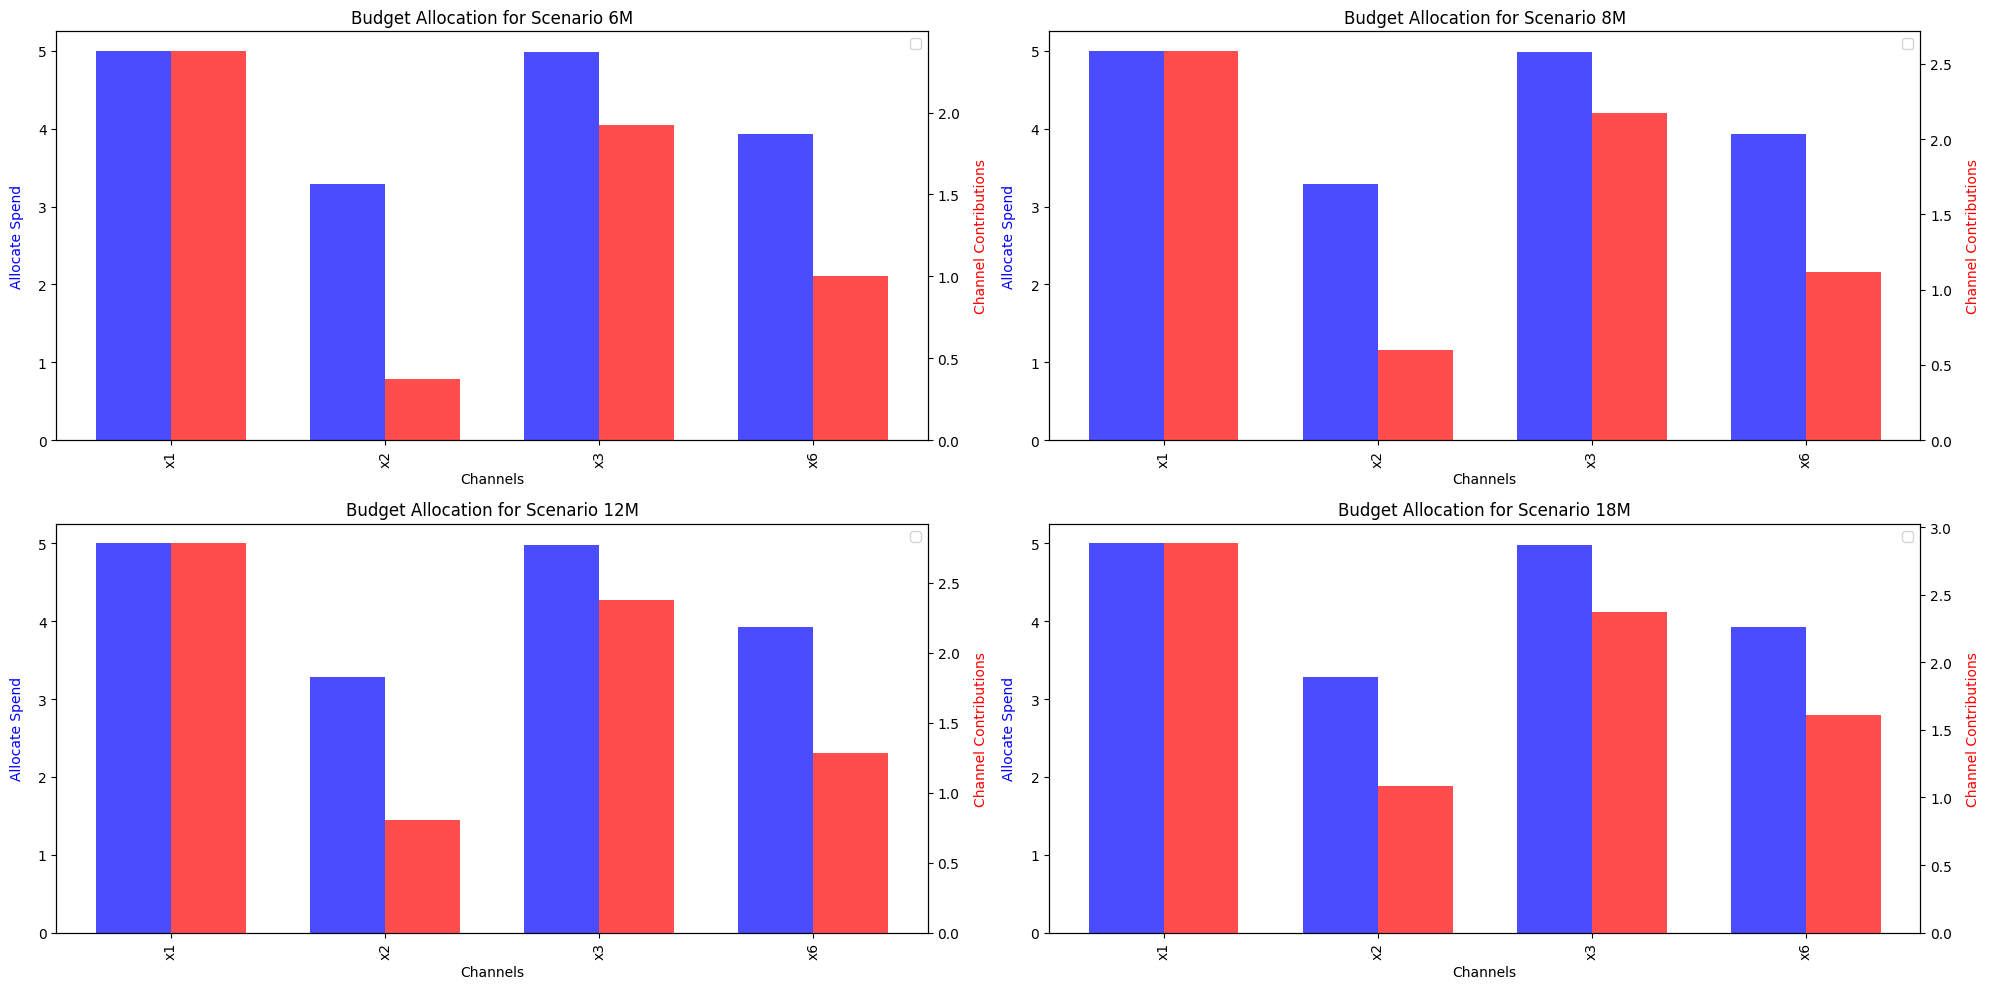

In [ ]:
fig_main, ax_main = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
for i, scenario in enumerate(scenarios_result):
    row = i // 2
    col = i % 2
    _, ax = mmm.plot_budget_allocation(samples=scenario, ax=ax_main[row, col])
    ax.set_title(f"Budget Allocation for Scenario {scenarios[i] * total_budget:.0f}M")
plt.tight_layout()
plt.show()

OLD VERSION

In [ ]:
sigmoid_response_curve_fig = mmm.plot_direct_contribution_curves(
show_fit = True, method='michaelis-menten'
)

TypeError: MMM.plot_direct_contribution_curves() got an unexpected keyword argument 'method'

In [ ]:
fig = mmm.plot_direct_contribution_curves(show_fit=True, method="michaelis-menten", same_axes=True)
[ax.set(xlabel="x") for ax in fig.axes];

TypeError: MMM.plot_direct_contribution_curves() got an unexpected keyword argument 'method'

In [ ]:
from pymc_marketing.mmm.utils import (
    estimate_menten_parameters,
    michaelis_menten,
    extense_sigmoid,
    estimate_sigmoid_parameters
)

ImportError: cannot import name 'extense_sigmoid' from 'pymc_marketing.mmm.utils' (/usr/local/lib/python3.10/dist-packages/pymc_marketing/mmm/utils.py)

In [ ]:
#python
menten_params = mmm.compute_channel_curve_optimization_parameters_original_scale(method='michaelis-menten')#'michaelis-menten'
menten_params

AttributeError: 'DelayedSaturatedMMM' object has no attribute 'compute_channel_curve_optimization_parameters_original_scale'

In [ ]:
#January
impressions_per_euro = {
    'x1': 500,
    'x2': 800,
    'x3': 600,
    'x4': 300,
    'x5': 100,
    'x6': 400,
}

fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(12, 8),
)

x = np.linspace(0, 0.002, 10000)

for i, channel in enumerate(menten_params.keys()):
    y = michaelis_menten(x = x, alpha = menten_params[channel][0],
                            lam = menten_params[channel][1] / impressions_per_euro[channel])

    # y = extense_sigmoid(x = x, alpha = menten_params[channel][0],
    #                         lam = menten_params[channel][1] / impressions_per_euro[channel])

    ax.plot(x, y, color=f"C{i}", linestyle='-', label=channel)

fig.suptitle("January Response Curve", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])  #Adjust the layout to make room for the suptitle
plt.legend()
plt.show()

In [ ]:
# Modified dictionary
menten_params_modified = {
    key: [value[0], value[1] / impressions_per_euro[key]]
    for key, value in menten_params.items()
}

# menten_params_april = {key: [value[0], value[1] / april_ipe[key]] for key, value in menten_params.items()}
# menten_params_may = {key: [value[0], value[1] / may_ipe[key]] for key, value in menten_params.items()}

menten_params_modified

In [ ]:
from pymc_marketing.mmm.budget_optimizer import (
    budget_allocator,
    calculate_expected_contribution,
    optimize_budget_distribution
)

In [ ]:
#python
total_budget = 1
#Define your channels
channels = list(menten_params.keys())
#The initial split per channel
budget_per_channel = total_budget / len(channels)
#Initial budget per channel as dictionary.
initial_budget_dict = {channel: budget_per_channel for channel in channels}

initial_contribution = calculate_expected_contribution(
    method='michaelis-menten',
    parameters = menten_params_modified,
    budget = initial_budget_dict
)

# Initial budget & contribution dictionary
initial_scenario = {
    'initial_contribution': initial_contribution,
    'initial_budget': initial_budget_dict,
}

pd.DataFrame(initial_scenario)

In [ ]:
# budget_bounds =  {
#   # 'Facebook_Impressions': [0, menten_params_modified["Facebook_Impressions"][1] * 8],
#   # 'Google_Impressions': [0, menten_params_modified["Google_Impressions"][1] * 8],
#   # 'Email_Impressions': [0, menten_params_modified["Email_Impressions"][1] * 8],
#   # 'Affiliate_Impressions': [0, menten_params_modified["Affiliate_Impressions"][1] * 8],
#   # 'Paid_Views': [0, menten_params_modified["Paid_Views"][1] * 8]

#     'x1': [0, 100_000],
#   'x2': [0, 150_000],
#   'x3': [0, 150_000],
#   'x4': [0, 40_000],
#   'x5': [0, 100_000],
#   'x6': [0, 120_000],
# }

# result_cheap_menten = budget_allocator(
#             method='michaelis-menten',
#             total_budget=total_budget,
#             channels=channels,
#             parameters=menten_params_modified,
#             budget_ranges=budget_bounds,
#         )

# result_cheap_menten

In [ ]:
upper = total_budget/10#500_000

budget_bounds =  {
  # 'Facebook_Impressions': [0, menten_params_modified["Facebook_Impressions"][1] * 8],
  # 'Google_Impressions': [0, menten_params_modified["Google_Impressions"][1] * 8],
  # 'Email_Impressions': [0, menten_params_modified["Email_Impressions"][1] * 8],
  # 'Affiliate_Impressions': [0, menten_params_modified["Affiliate_Impressions"][1] * 8],
  # 'Paid_Views': [0, menten_params_modified["Paid_Views"][1] * 8]

    'x1': [0, upper],
  'x2': [0, upper],
  'x3': [0, upper],
  'x4': [0, upper],
  'x5': [0, upper],
  'x6': [0, upper],
}

result_menten = budget_allocator(
            method='michaelis-menten',
            total_budget=total_budget,
            channels=channels,
            parameters=menten_params_modified,
            budget_ranges=budget_bounds,
        )

result_menten

In [ ]:
temp =pd.DataFrame(initial_scenario)
temp['initial_contribution'][6]

In [ ]:
result_menten['estimated_contribution'][6]

In [ ]:
result_menten['estimated_contribution'][6]/temp['initial_contribution'][6]

In [ ]:
#Use the function `compare_budget_scenearios` to validate
#The estimated contribution from one scenario agains the other
figure_ = mmm.plot_budget_scenearios(base_data=initial_scenario, method='michaelis-menten', scenarios_data=[result_menten])#result_cheap_menten,

In [ ]:
while(True):

In [ ]:
while(True):

In [ ]:
while(True):
  pass

KeyboardInterrupt: 